### Problem Statement ###

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.o reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

**Churn Phases**
- In ‘good’ phase the customer is happy with the service and behaves as usual
- In ‘action’ phase The customer experience starts to sore in this phase
- In ‘churn’ phase the customer is said to have churned

#### Business Goal ####

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

#### Outcomes ####

- Predict churn only on high-value customers
- Predict usage-based definition to define churn


### Step 1: Data Exploration

In [130]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')


In [131]:
# Importing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:.2f}'.format)


plt.style.use('fivethirtyeight')

In [132]:
telecom_df = pd.read_csv('telecom_churn_data.csv')

In [133]:
# Let's see the head of our master dataset
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [134]:
# Let's check the dimensions of the dataframe
telecom_df.shape

(99999, 226)

In [135]:
# let's look at the statistical aspects of the dataframe
telecom_df.describe(include='all')

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,99999.00,99999.00,98981.00,98981.00,98981.00,99999,99398,98899,98340,99999.00,99999.00,99999.00,99999.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.

In [136]:
# Let's see the type of each column
telecom_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [137]:
## Below columns are breaking the convention. So we will rename them appropriately
vbc_cols = [col for col in telecom_df.columns if 'vbc' in col]
print(vbc_cols)

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']


In [138]:
telecom_df.rename(columns = {'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

In [139]:
#DataType Correction 
object_df = telecom_df.select_dtypes(include='object')
object_df.head()

#Looks like all are datetime object

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [140]:
#convert object to date time

for col in object_df.columns:
    telecom_df[col] = pd.to_datetime(telecom_df[col])

In [141]:
telecom_df.shape

(99999, 226)

We are now ready to cleanse the data and create a Manageable Data Set for further processing

## Step 2 : Data Cleansing

**Common Utility Functions**

In [142]:
# Function which returns the columns with missing values > the cutoff percentage
# Argument: cutoff percentage between 1 - 100
def calculate_missing_values(data, cutoff):
    missing_percent= round(data.isna().sum() / len(data.index) * 100)
    print("{} features having more than {}% missing values:".format(len(missing_percent[missing_percent > cutoff]), cutoff))
    return missing_percent[missing_percent > cutoff]

#Function to handle missing values across months 
# Argument: Take list of column names without month number suffix 
def impute_zero_in_missing(data, columnList):
    for feature in [col + suffix for suffix in ['_6','_7','_8','_9'] for col in columnList]:
        data[feature].fillna(0, inplace=True)
        

#Function to drop columns across months
def drop_columns(data,columnList):
    for feature in [col+suffix for suffix in ['_6','_7','_8','_9'] for col in columnList]:
        data.drop([feature],inplace=True, axis=1)

Drop columns which have only null values

In [143]:
telecom_df[telecom_df.isnull().all(axis=1)]

##Looks like there are no columns with only null values

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9


Drop all columns with 1 unique value 

In [144]:
unique_cols = telecom_df.nunique()
unique_cols[unique_cols == 1]

circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
last_date_of_month_9    1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_og_t2c_mou_9        1
std_ic_t2o_mou_6        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_8        1
std_ic_t2o_mou_9        1
dtype: int64

In [145]:
telecom_df.drop(unique_cols[unique_cols == 1].index, inplace=True, axis=1)

In [146]:
telecom_df.shape

(99999, 210)

Drop columns with missing values greater than 70% or impute the same

In [147]:
calculate_missing_values(telecom_df, 50)

40 features having more than 50% missing values:


date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_last_rech_data_9   74.00
total_rech_data_6          75.00
total_rech_data_7          74.00
total_rech_data_8          74.00
total_rech_data_9          74.00
max_rech_data_6            75.00
max_rech_data_7            74.00
max_rech_data_8            74.00
max_rech_data_9            74.00
count_rech_2g_6            75.00
count_rech_2g_7            74.00
count_rech_2g_8            74.00
count_rech_2g_9            74.00
count_rech_3g_6            75.00
count_rech_3g_7            74.00
count_rech_3g_8            74.00
count_rech_3g_9            74.00
av_rech_amt_data_6         75.00
av_rech_amt_data_7         74.00
av_rech_amt_data_8         74.00
av_rech_amt_data_9         74.00
arpu_3g_6                  75.00
arpu_3g_7                  74.00
arpu_3g_8                  74.00
arpu_3g_9                  74.00
arpu_2g_6                  75.00
arpu_2g_7                  74.00
arpu_2g_8 

Impute Missing Value as 0 for all the **Recharge, Revenue, Night Pack, Fb User** Fields

In [148]:
missingValueColumnList=['total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data'
                       , 'arpu_3g', 'arpu_2g', 'night_pck_user', 'fb_user']

In [149]:
# Since the minimum value is 1, we are going to handle NA values by imputing with 0 
# which means we are assuming there were no recharges done by the customer
impute_zero_in_missing(telecom_df, missingValueColumnList)

In [150]:
calculate_missing_values(telecom_df, 50)

4 features having more than 50% missing values:


date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_last_rech_data_9   74.00
dtype: float64

In [151]:
calculate_missing_values(telecom_df, 7)

31 features having more than 7% missing values:


onnet_mou_9                 8.00
offnet_mou_9                8.00
roam_ic_mou_9               8.00
roam_og_mou_9               8.00
loc_og_t2t_mou_9            8.00
loc_og_t2m_mou_9            8.00
loc_og_t2f_mou_9            8.00
loc_og_t2c_mou_9            8.00
loc_og_mou_9                8.00
std_og_t2t_mou_9            8.00
std_og_t2m_mou_9            8.00
std_og_t2f_mou_9            8.00
std_og_mou_9                8.00
isd_og_mou_9                8.00
spl_og_mou_9                8.00
og_others_9                 8.00
loc_ic_t2t_mou_9            8.00
loc_ic_t2m_mou_9            8.00
loc_ic_t2f_mou_9            8.00
loc_ic_mou_9                8.00
std_ic_t2t_mou_9            8.00
std_ic_t2m_mou_9            8.00
std_ic_t2f_mou_9            8.00
std_ic_mou_9                8.00
spl_ic_mou_9                8.00
isd_ic_mou_9                8.00
ic_others_9                 8.00
date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_la

We will drop all features which have more than 70% missing values

In [152]:
drop_columns(telecom_df,['date_of_last_rech_data'])

In [153]:
calculate_missing_values(telecom_df, 7)

27 features having more than 7% missing values:


onnet_mou_9        8.00
offnet_mou_9       8.00
roam_ic_mou_9      8.00
roam_og_mou_9      8.00
loc_og_t2t_mou_9   8.00
loc_og_t2m_mou_9   8.00
loc_og_t2f_mou_9   8.00
loc_og_t2c_mou_9   8.00
loc_og_mou_9       8.00
std_og_t2t_mou_9   8.00
std_og_t2m_mou_9   8.00
std_og_t2f_mou_9   8.00
std_og_mou_9       8.00
isd_og_mou_9       8.00
spl_og_mou_9       8.00
og_others_9        8.00
loc_ic_t2t_mou_9   8.00
loc_ic_t2m_mou_9   8.00
loc_ic_t2f_mou_9   8.00
loc_ic_mou_9       8.00
std_ic_t2t_mou_9   8.00
std_ic_t2m_mou_9   8.00
std_ic_t2f_mou_9   8.00
std_ic_mou_9       8.00
spl_ic_mou_9       8.00
isd_ic_mou_9       8.00
ic_others_9        8.00
dtype: float64

All columns except date columns are for the month 9 i.e the Churn phase. 
This data will be eventually dropped when we tag churn/no churn, 
hence we will be skipping imputing these fields related to month 9

### Step 3: Data Preparation ###

**Filter in High Value Customers which are the target of our analysis**

* A high-value customers is defined as follows:

- Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [154]:
# Create new column total recharge amount for data for aiding in finding High Value customer 

telecom_df['total_rech_amt_data_6'] = telecom_df.av_rech_amt_data_6 * telecom_df.total_rech_data_6
telecom_df['total_rech_amt_data_7'] = telecom_df.av_rech_amt_data_7 * telecom_df.total_rech_data_7
telecom_df['total_rech_amt_data_8'] = telecom_df.av_rech_amt_data_8 * telecom_df.total_rech_data_8

In [155]:
#Create column for holding average of total recharge amount for good phase (the months June (6) and July (7))
# We add the total recharge amount of call and data and find the average across two months
telecom_df['total_avg_rech_amnt_Good_Phase'] = (telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_data_6 \
                                               + telecom_df.total_rech_amt_7+ telecom_df.total_rech_amt_data_7)/2

In [156]:
# filter values greater than 70th percentile of total average recharge amount for good phase 
seventieth_percentile = telecom_df.total_avg_rech_amnt_Good_Phase.quantile(0.7)

telecom_df_high_val_cust = telecom_df[telecom_df.total_avg_rech_amnt_Good_Phase > seventieth_percentile]

In [157]:
print("70th Percentile of Average Recharge amount in Good Phase (June and July month) is ", seventieth_percentile)

70th Percentile of Average Recharge amount in Good Phase (June and July month) is  478.0


In [158]:
telecom_df_high_val_cust.shape


(29953, 210)

**Define the Target Variable Churn based on the following criteria**

* A Churned Customer is defined as follows : 
* A Customer has churned (churn=1, else 0) if in the Ninth Month he/she has not made any calls (either incoming or outgoing) 
* AND have not used mobile internet even once. 



In [159]:
#Add a new column "churn", values would be either 1 (churn) or 0 (non-churn)
telecom_df_high_val_cust['churn'] = \
        np.where(telecom_df_high_val_cust[['total_ic_mou_9','total_og_mou_9', \
                                           'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1) == 0, 1,0)

0   0.92
1   0.08
Name: churn, dtype: float64


<AxesSubplot:>

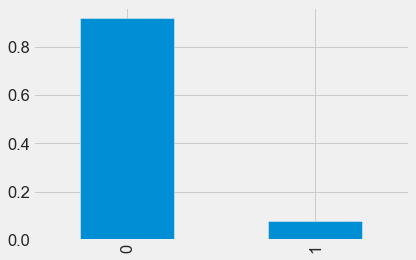

In [160]:
# Find out the % of churn/non churn customers
churn_percentage = telecom_df_high_val_cust.churn.value_counts(normalize=True)
print(churn_percentage)
churn_percentage.plot.bar()

**Observation** : The churn percentage is around 8%. This indicates that there is a slight imbalance in the dataset which will need to be corrected in modelling

**Drop all data of the ninth Month as that is our Target Variable**


In [161]:
churn_month_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

In [162]:
churn_month_columns

Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'date_of_last_rech_9', 'last_day_rch_amt_9', 'total_rech_data_9',
       'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9',
       'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9',
       'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9',
       'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9'],

In [163]:
# drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

In [164]:
telecom_df_high_val_cust.shape

(29953, 160)

### Step 4 : EDA ### 

We will now perform EDA and try to get insights into the data. 
Based on the insights we could define our approach to training, remove outliers, remove highly correlated variables

In [165]:
#CheckPoint 1 
telecom_eda_df = telecom_df_high_val_cust.copy()


#### 4.1 Bi variate Analysis of Various Variables with the Churn Variable ####
We will draw trends of the selected categorical variables data wrt to the Label, Churn and see if we can derive any meaningful insights

**Utility Functions**

In [166]:
# create box plot for  6th, 7th and 8th month
def create_box_plot(column):
    plt.figure(figsize=(15,10))
    df = telecom_eda_df
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=column+"_6",x="churn", showfliers=False)
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=column+"_7",x="churn", showfliers=False)
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=column+"_8",x="churn", showfliers=False)
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
    


In [167]:
# create box plot for  6th, 7th and 8th month
def create_bar_plot(column):
    plt.figure(figsize=(15,10))
    df = telecom_eda_df
    plt.subplot(2,3,1)
    sns.barplot(data=df, y=column+"_6",x="churn")
    plt.subplot(2,3,2)
    sns.barplot(data=df, y=column+"_7",x="churn")
    plt.subplot(2,3,3)
    sns.barplot(data=df, y=column+"_8",x="churn")
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [168]:
def showbarlabel(graph, rotate=0):
    graph.set_xticklabels(graph.get_xticklabels(),rotation=rotate)
    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

In [169]:
def plot_bar(by,rotate=0):
    df = telecom_df_high_val_cust
    graph = df[by].value_counts(sort=True).plot(kind='bar')
    showbarlabel(graph,rotate)

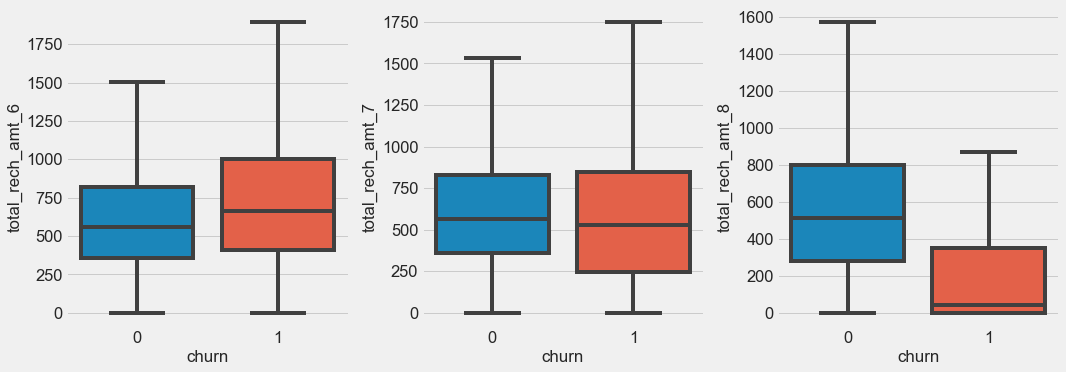

In [170]:
# Ploting for Total recharge amount :
create_box_plot('total_rech_amt')

**Observation** : Total Recharge amount drops in month 8 indicating Churn 

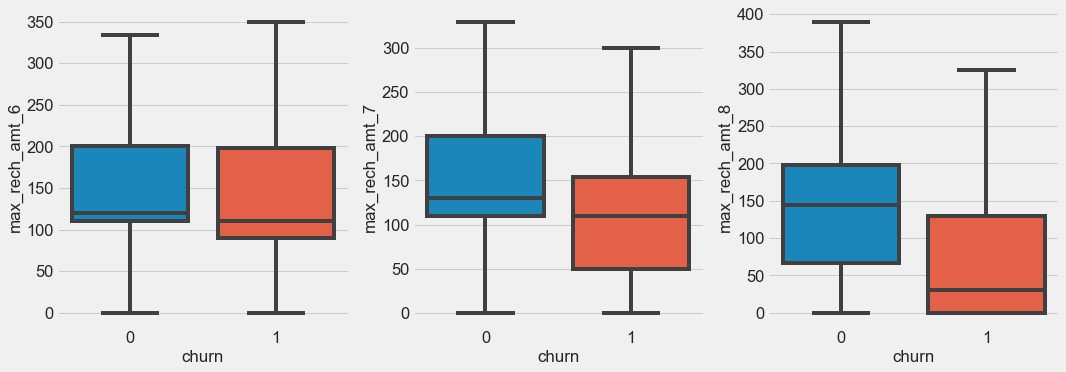

In [171]:
# Ploting for maximum recharge amount :
create_box_plot('max_rech_amt')

**Observation**  : We can see that there is a huge drop in maximum recharge amount for churned customers in the 8th month i.e action phase


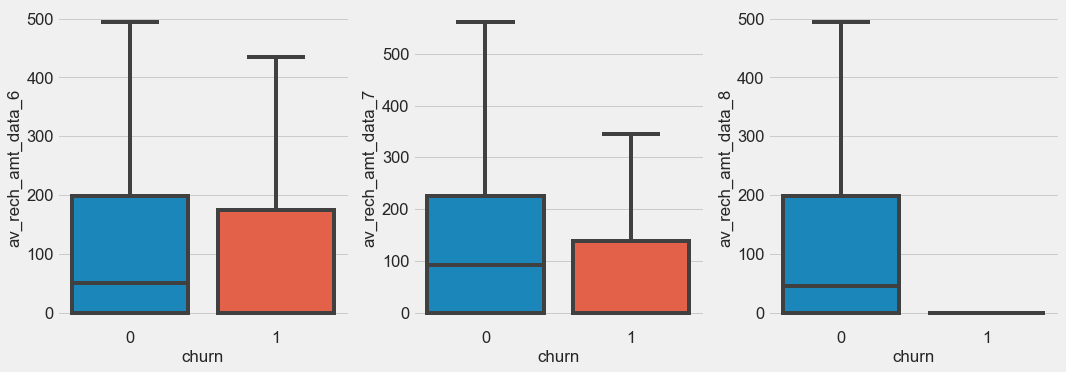

In [172]:
create_box_plot('av_rech_amt_data')

**Observation** : Average Recharge amount drops in month 8 indicating Churn 

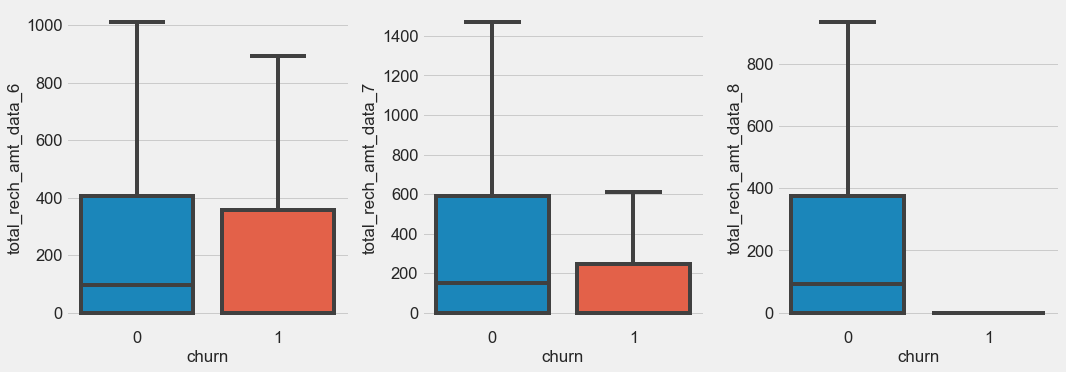

In [173]:
# Ploting for total recharge amount data :
create_box_plot('total_rech_amt_data')


**Observation** : We can see a drop in the total recharge for data for churned customers in the 8th Month i.e Action Phase

In [174]:
# all Recharge Number related column list
recharge_num_columns = [col for col in telecom_df_high_val_cust if 'rech_num' in col.lower()]
recharge_num_columns

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8']

In [175]:
100*telecom_df_high_val_cust[recharge_num_columns].isnull().sum()/len(telecom_df_high_val_cust.index)
# We don't have any missing values here

total_rech_num_6   0.00
total_rech_num_7   0.00
total_rech_num_8   0.00
dtype: float64

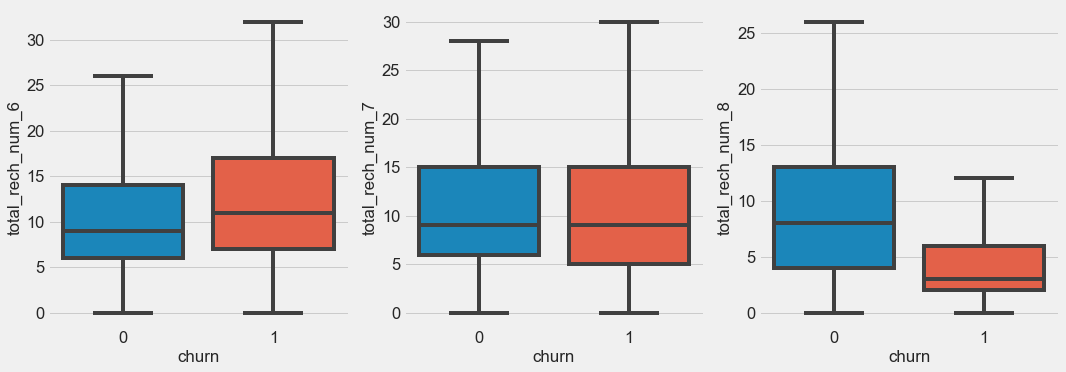

In [176]:
# Ploting for total recharge number:
create_box_plot('total_rech_num')

**Observation** : We can see that there is a huge drop in total recharge number for churned customers in the 8th month i.e action phase

In [177]:
# all Recharge data related column list
recharge_data_columns = [col for col in telecom_df_high_val_cust if 'rech_data' in col.lower()]
recharge_data_columns

['total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8']

In [178]:
100*telecom_df_high_val_cust[recharge_data_columns].isnull().sum()/len(telecom_df_high_val_cust.index)
# We don't have any missing values here

total_rech_data_6   0.00
total_rech_data_7   0.00
total_rech_data_8   0.00
max_rech_data_6     0.00
max_rech_data_7     0.00
max_rech_data_8     0.00
dtype: float64

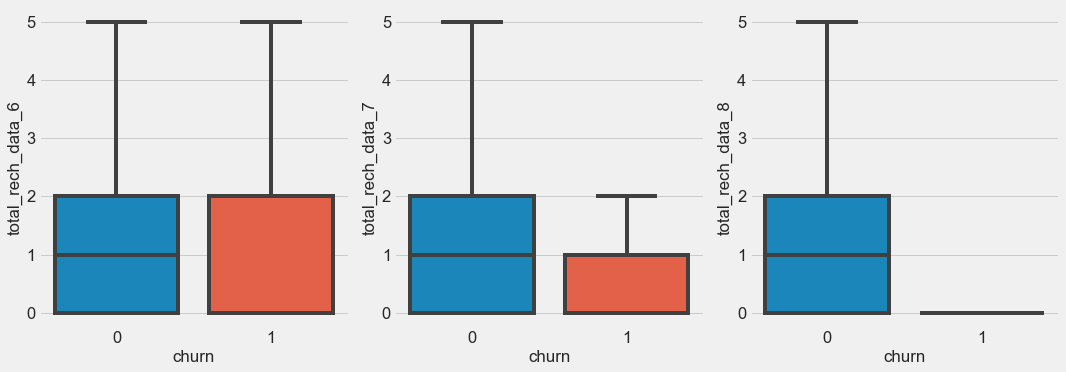

In [179]:
# Ploting for total recharge data:
create_box_plot('total_rech_data')

**Observation** : Again we can see that there is a huge drop in total recharge amount data for churned customers in the 8th month i.e action phase

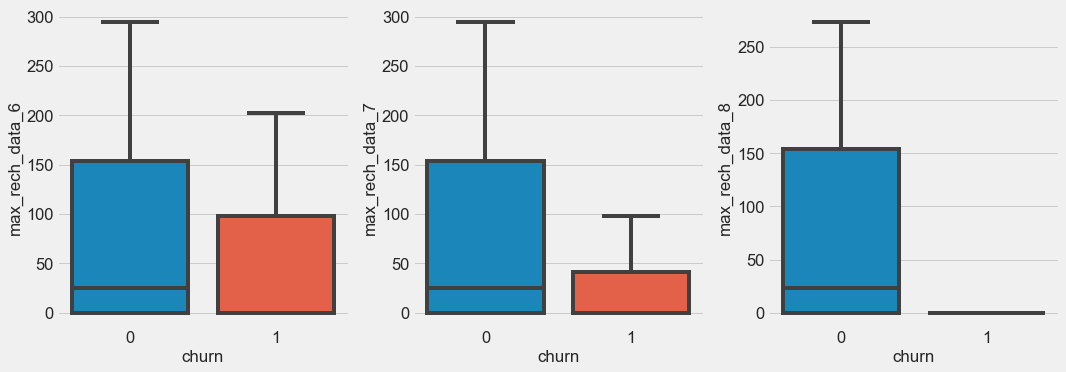

In [180]:
# Ploting for max recharge for data:
create_box_plot('max_rech_data')

**Observation** : There is a huge drop in max recharge amount data for churned customers in the 8th month i.e action phase 

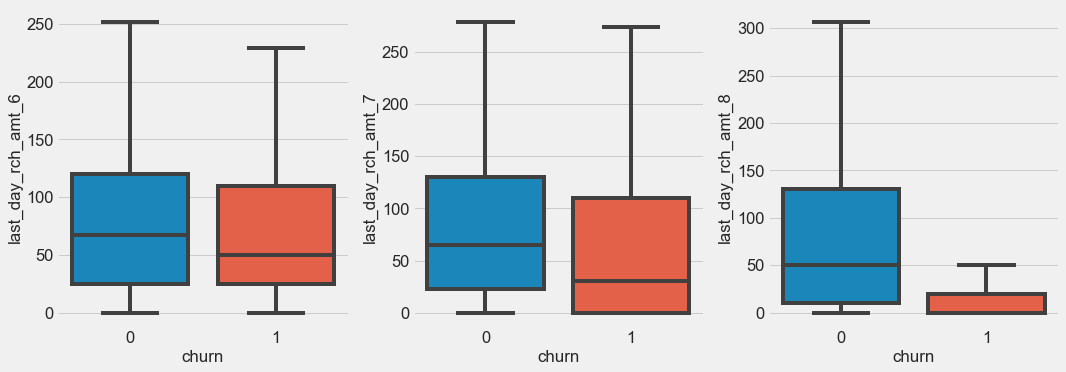

In [181]:
# Ploting for Last  day recharge amount  :
create_box_plot('last_day_rch_amt')

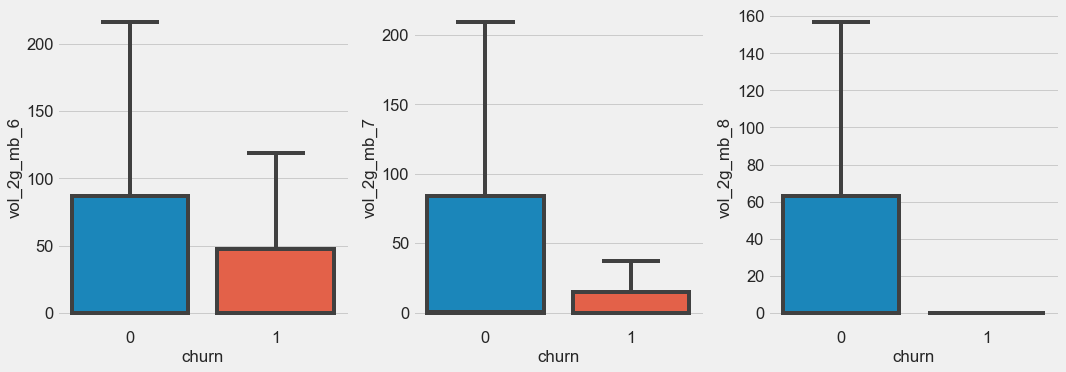

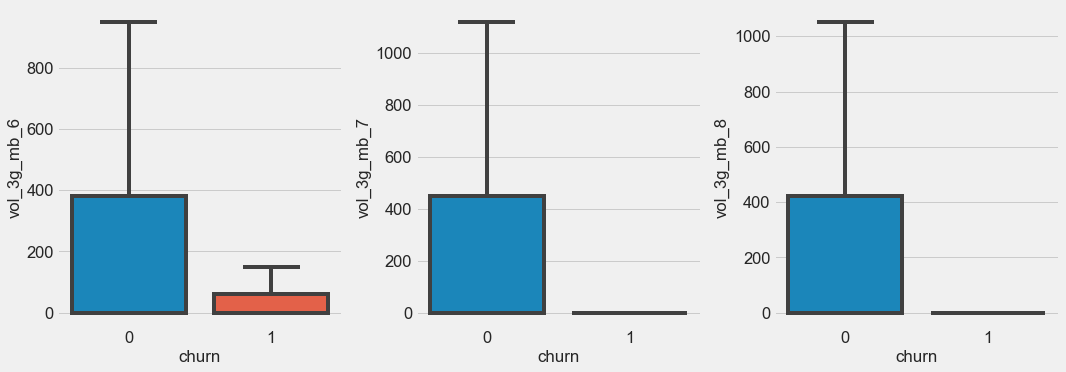

In [182]:
# Ploting for volume of 2G and 3G usage columns:
create_box_plot('vol_2g_mb')
create_box_plot('vol_3g_mb')

**Observation** 
We see 2g and 3g usage for churned customers drops in the 8th month i.e Action phase.

However in general we see the usage is low for churned customer across months. 

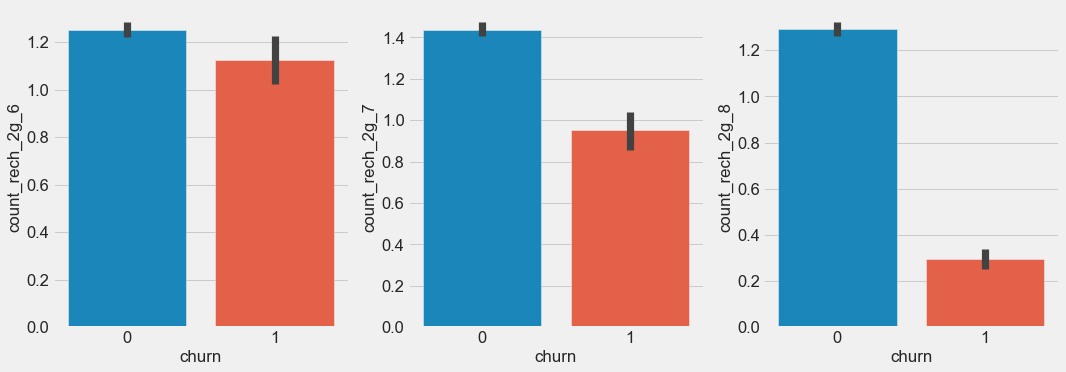

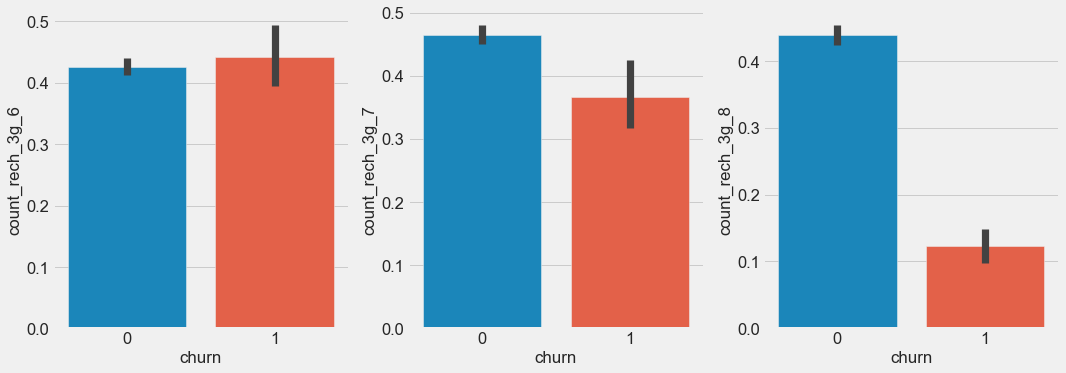

In [183]:
# Ploting for count of 2G and 3G recharge columns:
create_bar_plot('count_rech_2g')
create_bar_plot('count_rech_3g')

**Observation** 
We see 2g and 3g recharge counts for churned customers drops in the 8th month i.e Action phase.



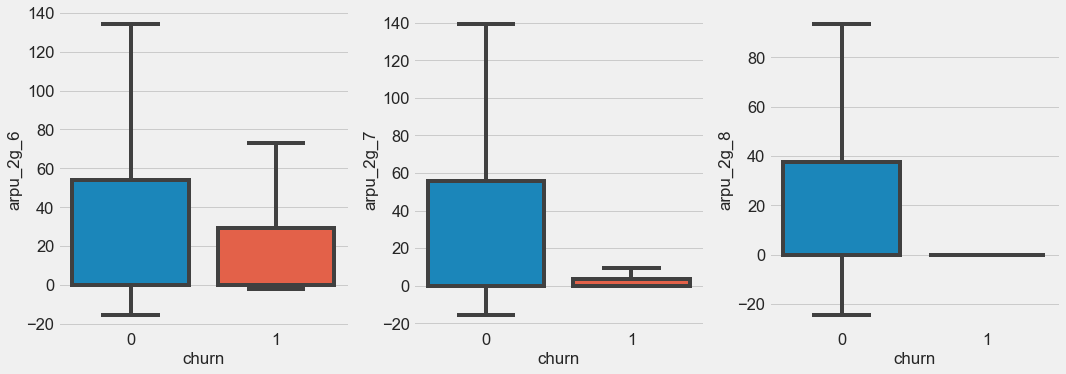

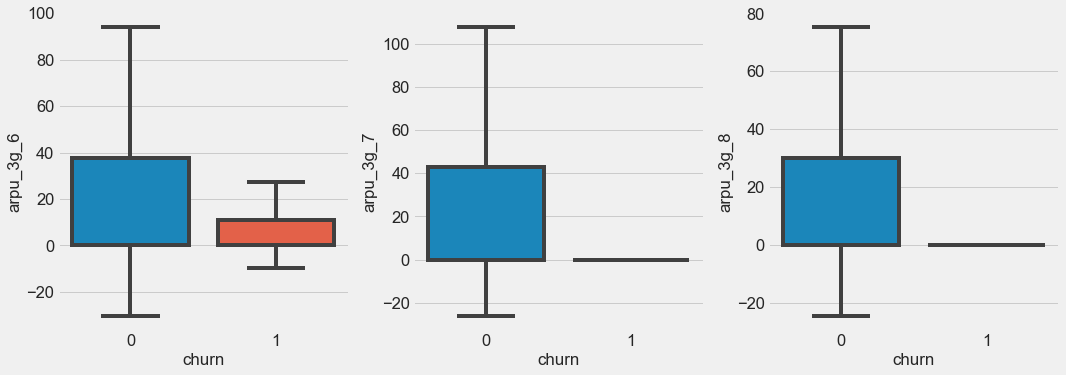

In [184]:
# Ploting for arpu of 2G and 3G usage columns:
create_box_plot('arpu_2g')
create_box_plot('arpu_3g')

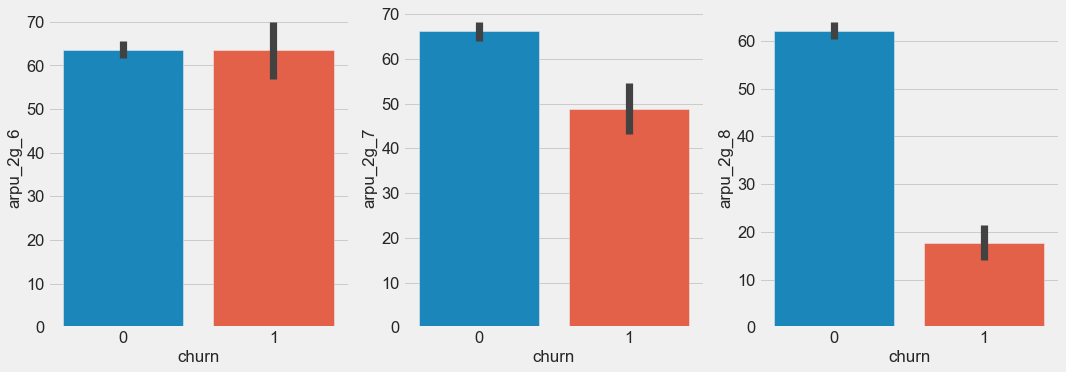

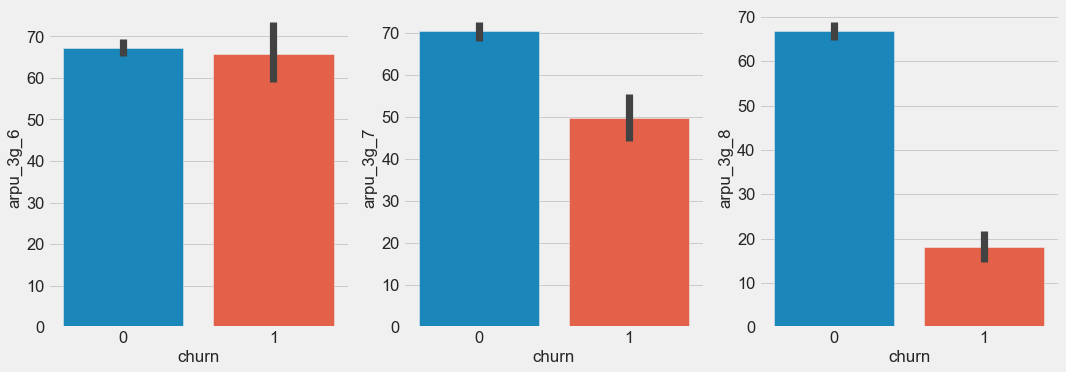

In [185]:
# Ploting bar plot for arpu of 2G and 3G usage columns:
create_bar_plot('arpu_2g')
create_bar_plot('arpu_3g')

**Observation** 
We see 2g and 3g arpu for churned customers drops in the 8th month i.e Action phase.



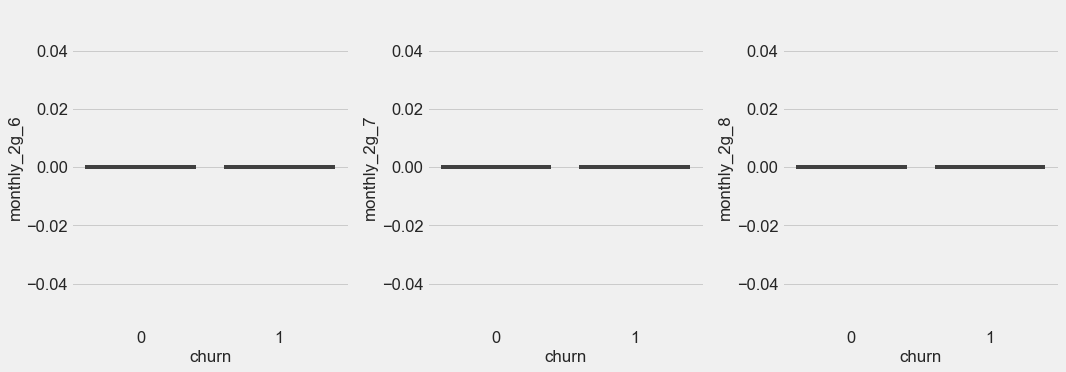

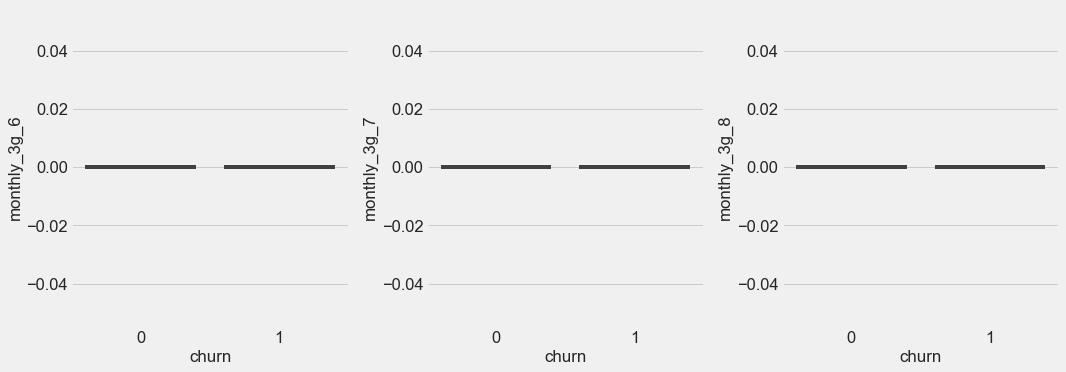

In [186]:
# Ploting for monthly subcription of 2G and 3G usage columns:
create_box_plot('monthly_2g')
create_box_plot('monthly_3g')

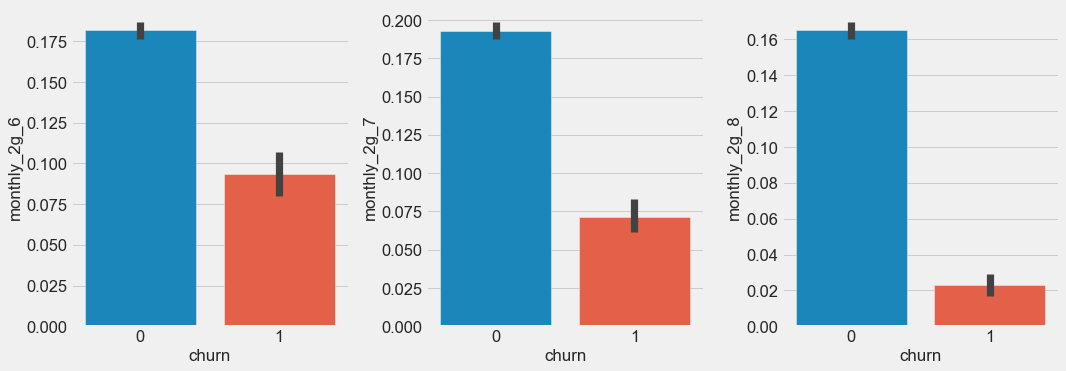

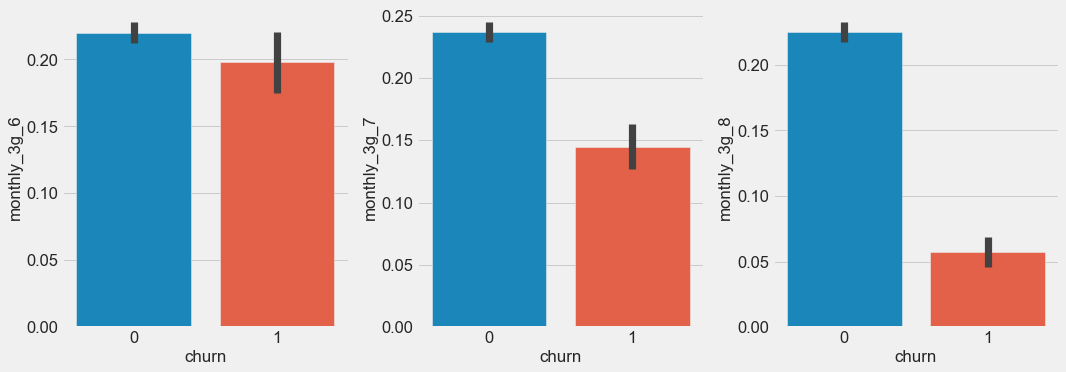

In [187]:
# Plotting a bar plot as box plot doesn't show any pattern
create_bar_plot('monthly_2g')
create_bar_plot('monthly_3g')

**Observation** 
We see 2g and 3g monthly subscription for churned customers drops in the 8th month i.e Action phase.



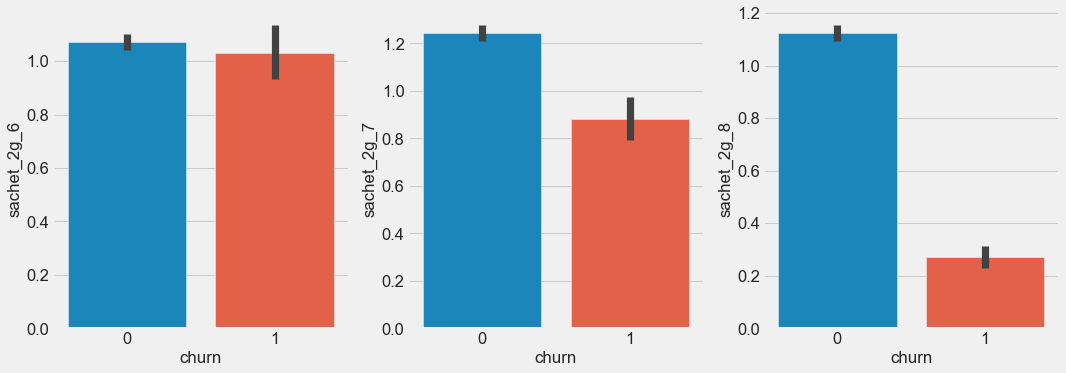

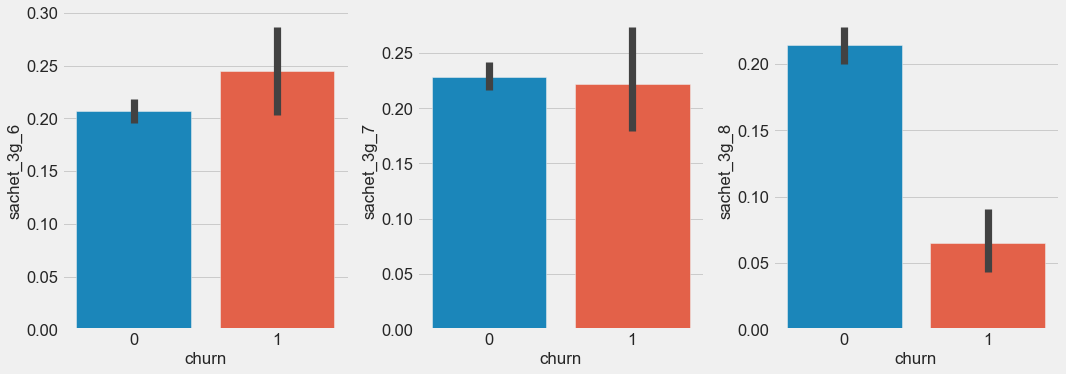

In [188]:
# Plotting for small duration subscription of 2g and 3g data
# Plotting a bar plot as box plot doesn't show any pattern
create_bar_plot('sachet_2g')
create_bar_plot('sachet_3g')

**Observation** 
We see 2g and 3g small duration subscription for churned customers drops in the 8th month i.e Action phase.





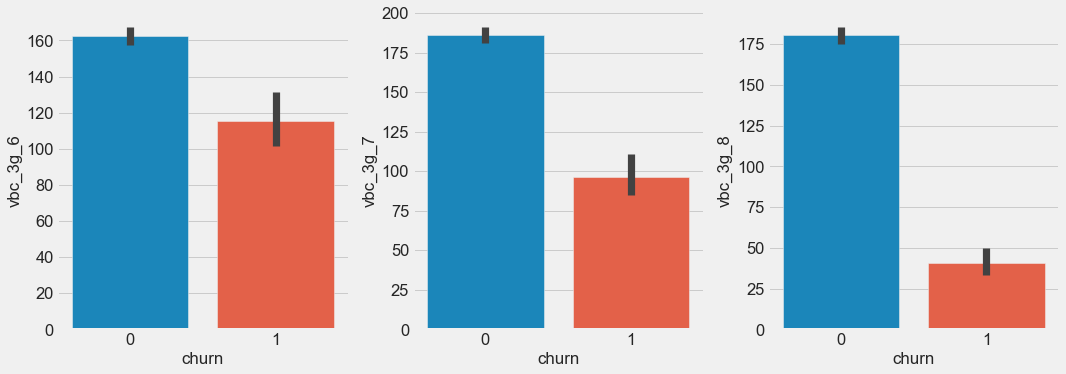

In [189]:
#Plotting volume based 3g usage
create_bar_plot('vbc_3g')

In [190]:
#Getting the  day  columns
day_columns = [col for col in telecom_df_high_val_cust if 'day' in col.lower()]
day_columns

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

In [191]:
100*telecom_df_high_val_cust[day_columns].isnull().sum()/len(telecom_df_high_val_cust.index)
# We don't have any missing values here

last_day_rch_amt_6   0.00
last_day_rch_amt_7   0.00
last_day_rch_amt_8   0.00
dtype: float64

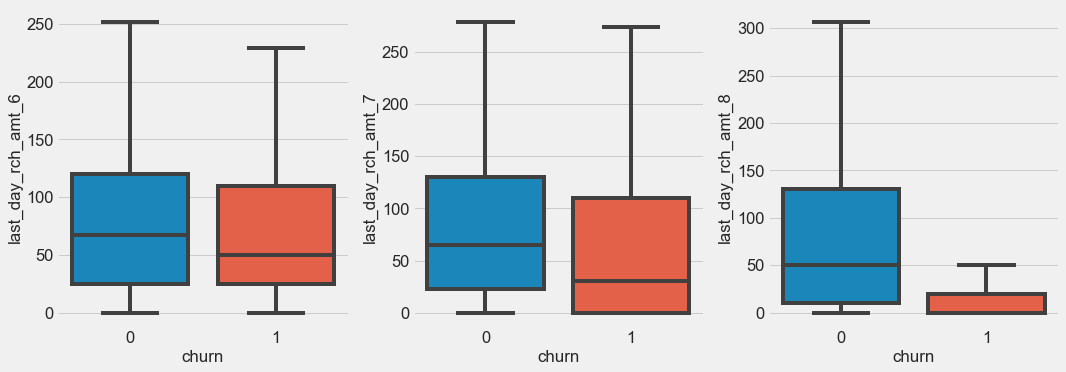

In [192]:
create_box_plot('last_day_rch_amt')

Huge drop in 8th month for last day recharge amount indicating  churn

In [193]:
# all Date column list
date_columns = [col for col in telecom_df_high_val_cust if 'date' in col.lower()]
date_columns

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [194]:
100*telecom_df_high_val_cust[date_columns].isnull().sum()/len(telecom_df_high_val_cust.index)


date_of_last_rech_6   0.24
date_of_last_rech_7   0.33
date_of_last_rech_8   1.94
dtype: float64

The missing value indicates that recharge date and the recharge value are missing together which means the customer didn't recharge for that month

In [195]:
telecom_df_high_val_cust[telecom_df_high_val_cust.date_of_last_rech_6.isnull()][['total_rech_data_6','date_of_last_rech_6']].head()

,total_rech_data_6,date_of_last_rech_6
91,0.00,NaT
414,0.00,NaT
6319,0.00,NaT
8125,0.00,NaT
8975,0.00,NaT


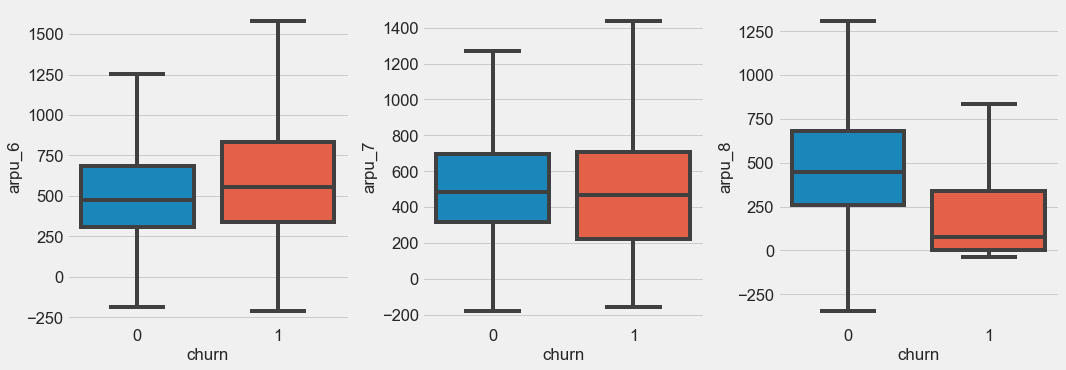

In [196]:
#Plot for ARPU 
create_box_plot('arpu')

**Observation** 
We see the ARPU for churned customers drops in the 8th month i.e Action phase.



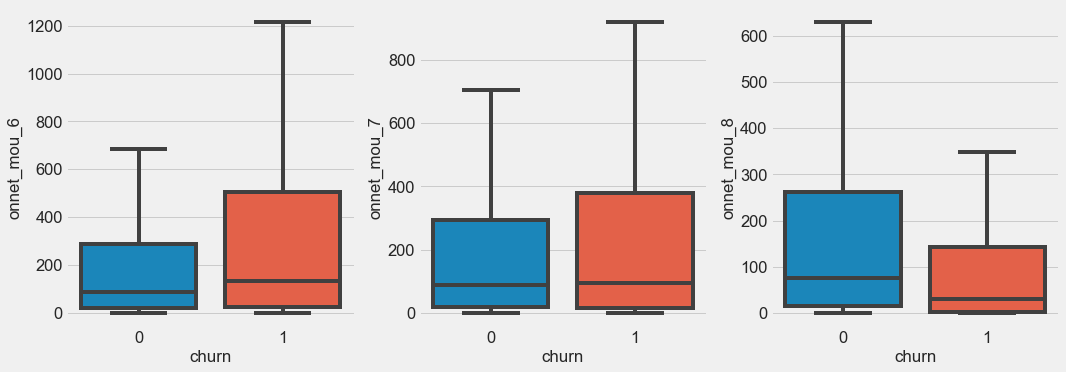

In [197]:
#Plot for Onnet Minutes of Usage
create_box_plot('onnet_mou')

The calls on service provider network drops in month 8 indicates Churn

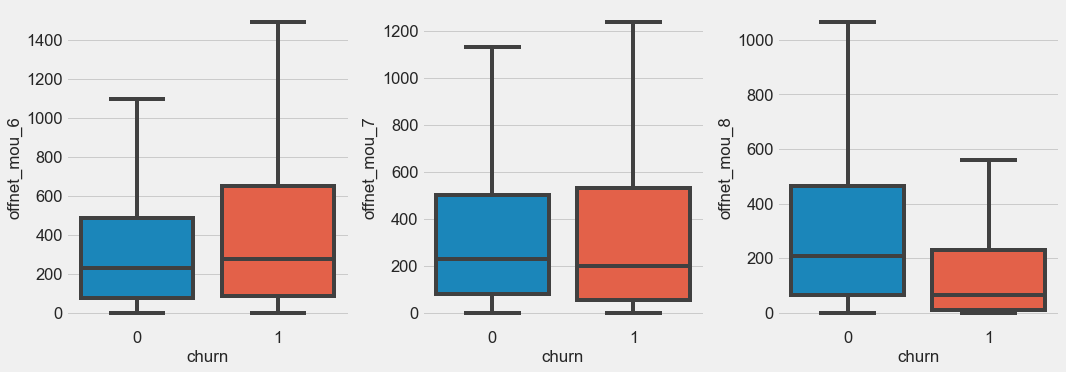

In [198]:
#Plot for Offnet Minutes of Usage
create_box_plot('offnet_mou')

The calls to different network drops in month 8 indicates Churn

#### General Observation from above EDA #### 
- We see churned customers drops in the 8th month i.e Action phase.
- We can also see that the trend reversal happens drastically in the 9th month. 
- In the 6th and 7th month, the variance captured between the Churned and Non Churned customers is not much.
- So to reduce dimensionality it might be a good idea to average out the values of both the columns and drop the individual months. 
- We can test this hypothesis in the models later


#### 4.2 Dimensionality Reduction  ####

Based  on the EDA done above, we will reduce the dimensionality to make forecasting of the trends easier based on the  features



**Dimensionality Reduction | Drop Highly Correlated Columns as a PreRequisite to EDA**

In [199]:
## Creating a copy to avoid regenerating master for each iterations
##Check point 2
training_df = telecom_eda_df.copy()

<AxesSubplot:>

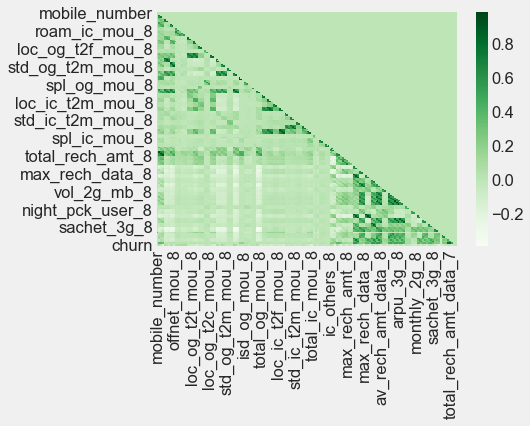

In [200]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = training_df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
sns.heatmap(cor, cmap='Greens', annot=False, )


Looks like there are strong multicollinearity issues, Lets drop data which is multi collinear

In [201]:
# Create correlation matrix
corr_matrix = training_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [202]:
## Filter columns of months where only all months are highly correlated, others we will ignore 
to_drop_filtered = ['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 #'std_og_t2m_mou_7',
 #'std_og_t2m_mou_8',
# 'isd_og_mou_7',
# 'isd_og_mou_8',
 #'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
# 'monthly_3g_7',
#'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
]

training_df.drop(to_drop_filtered, axis =1, inplace=True)


**Dimensionality Reduction | Drop the Date Columns as they are already factored in the other columns, Drop Mobile Number as its not meaningful to prediction**

In [203]:
training_df.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','mobile_number'], axis=1, inplace=True)

In [204]:
training_df.shape

(29953, 135)

<AxesSubplot:>

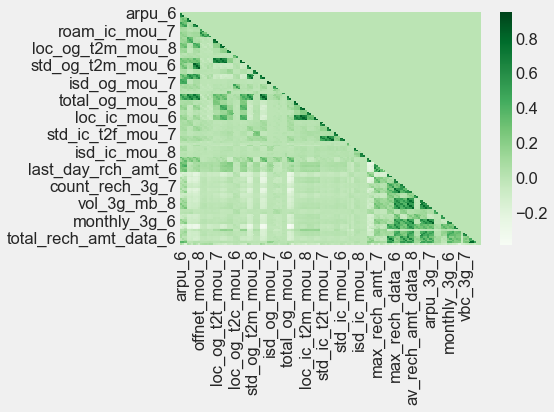

In [205]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = training_df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
sns.heatmap(cor, cmap='Greens', annot=False)

In [206]:
#Checkpoint 3
# We can run from checkpoints rather than run the entire notebook for validation
telecom_df_high_val_cust = training_df.copy()

**Dimensionality Reduction | Avg Out the 6th and 7th Month to reduce the number of Features**

In [207]:
# Creating Avg Column 

col_list = telecom_df_high_val_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_df_high_val_cust.shape)

for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_high_val_cust[avg_col_name] = (telecom_df_high_val_cust[col_6]  + telecom_df_high_val_cust[col_7])/ 2

(29953, 135)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2m_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
loc_ic_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
count_rech_3g
av_rech_amt_data
vol_2g_mb
vol_3g_mb
arpu_3g
night_pck_user
monthly_2g
monthly_3g
fb_user
vbc_3g
total_rech_amt_data


In [208]:
#Drop the individual columns

print (telecom_df_high_val_cust.shape)

col_list = telecom_df_high_val_cust.filter(regex='_6|_7').columns

telecom_df_high_val_cust.drop(col_list, axis=1, inplace=True)
telecom_df_high_val_cust.shape

(29953, 179)


(29953, 91)

#### Univariate Analysis 

**Analyse sample of  categorical variables and see if we can draw any meaningful insights**

In [209]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    counter = 0;
    for i in range(min(nCol,nGraphShown)):
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), pd._libs.tslibs.timestamps.Timestamp)):
            plt.subplot(nGraphRow, nGraphPerRow, counter+1)
            #increment the counter
            counter +=1
            if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
                #print(type(columnDf.iloc[0]))
                valueCounts = columnDf.value_counts()
                valueCounts.plot.bar()
            else:
                #print("Datatype is not number")
                columnDf.hist()
                plt.ylabel('counts')
                plt.xticks(rotation = 90)
                plt.title(f'{columnNames[i]} (column {i})')
        #else:
                #print("Timestamp found")
        
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

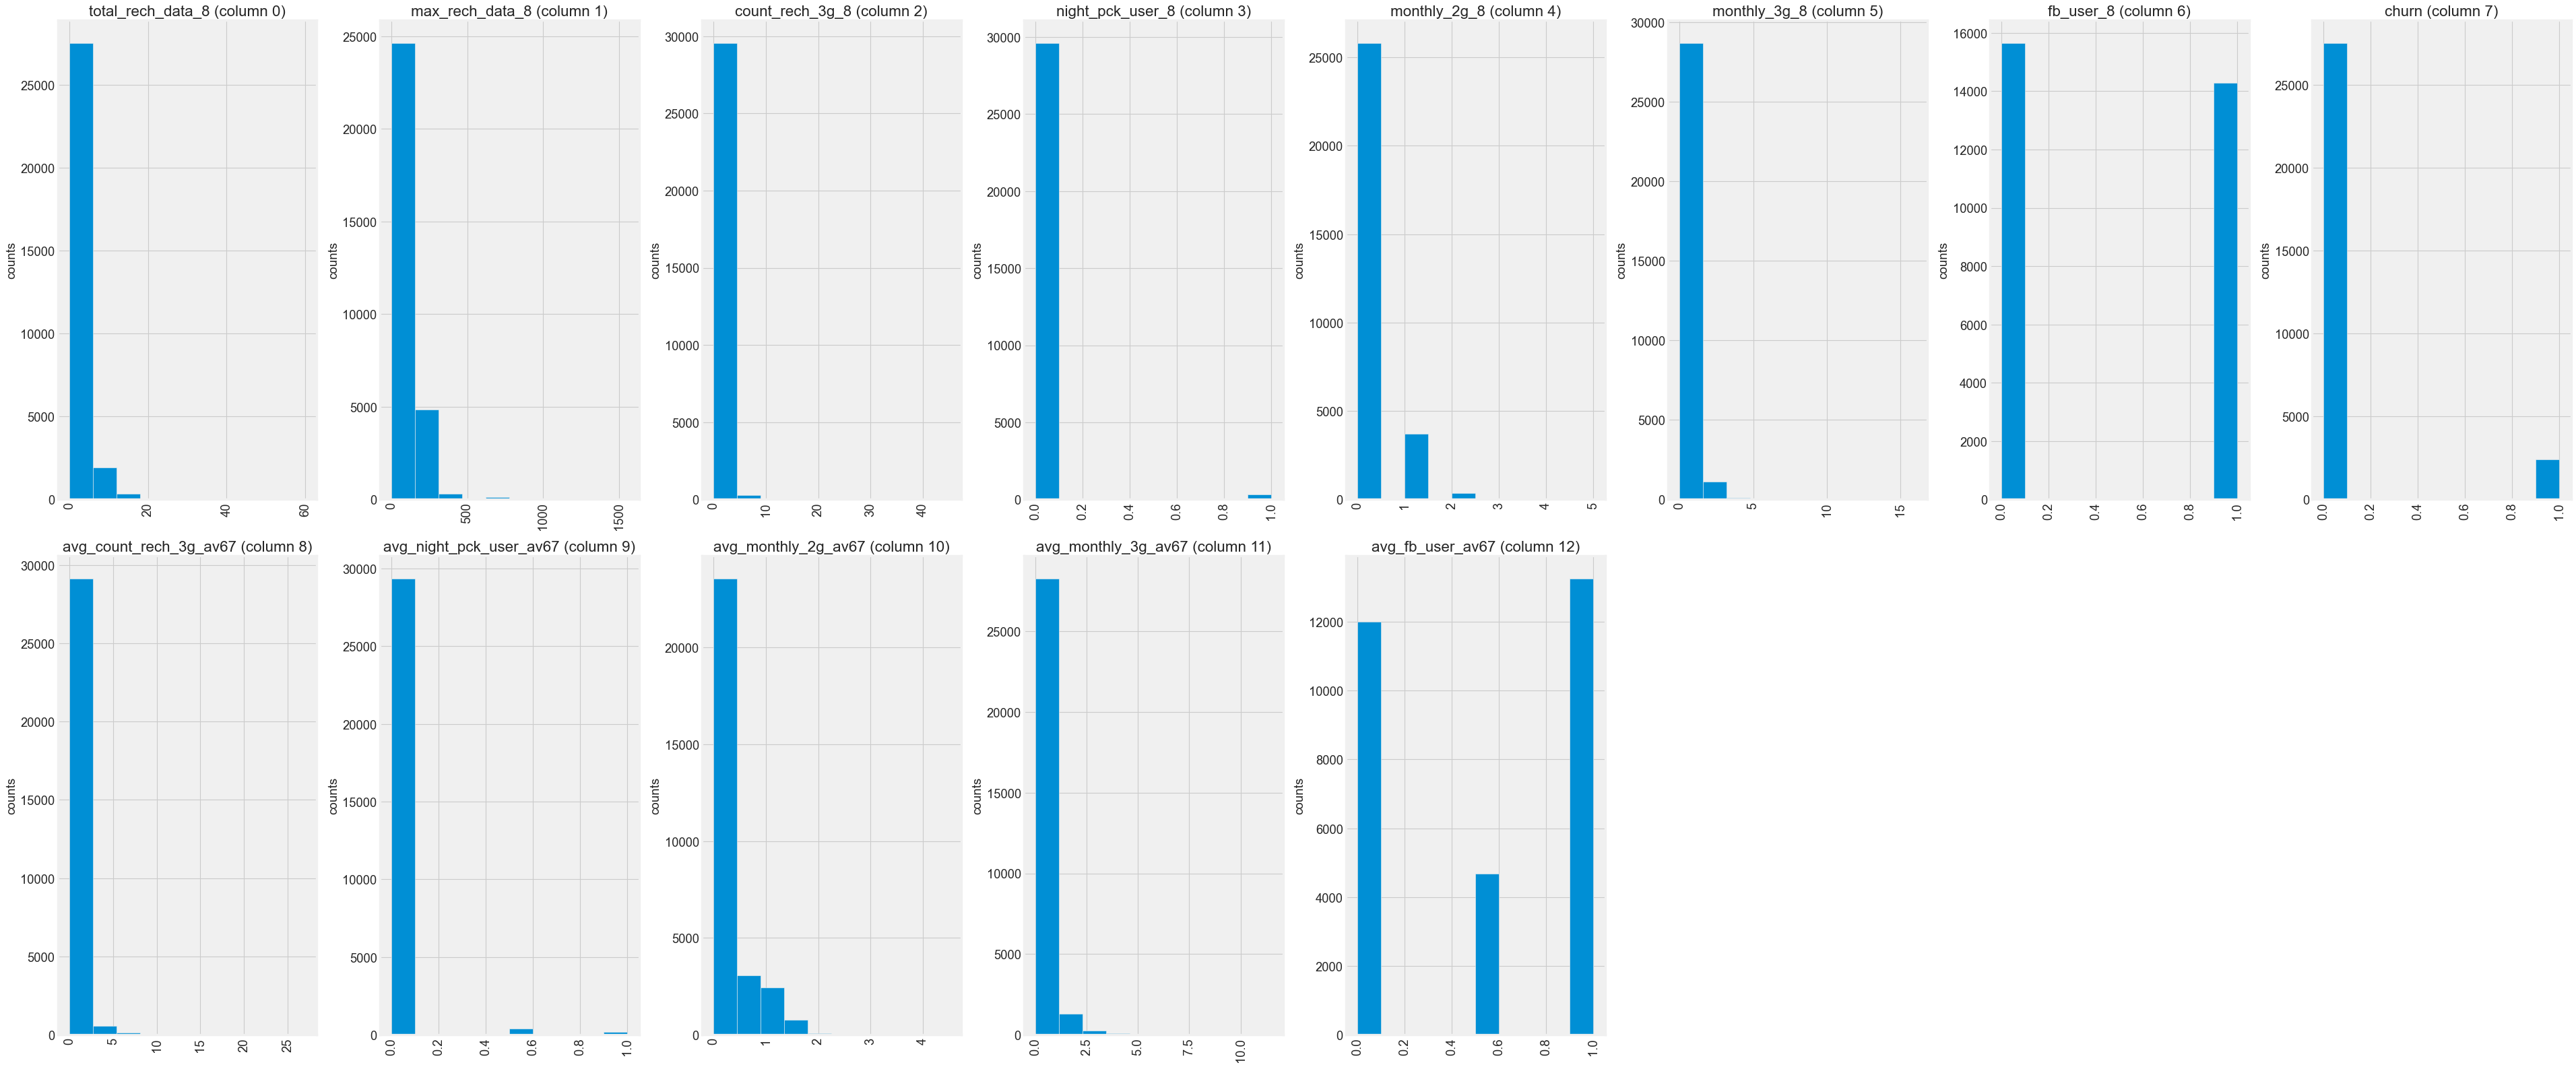

In [210]:
plotPerColumnDistribution(telecom_df_high_val_cust,30,8)

**Observation** -
* Histogram distribution shows twin peaks(bimodal) or single peaks on the lower bars of the distribution.
* The distribution is not normal, which indicates this could be a higher order linear or non linear distribution. 
* Smoothening may be required for better prediction. 
* The distribution is sparse or spread in one bucket

**Analysis of sample of  Numeric/Continuous Features to see if we can derive any trends**

In [211]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

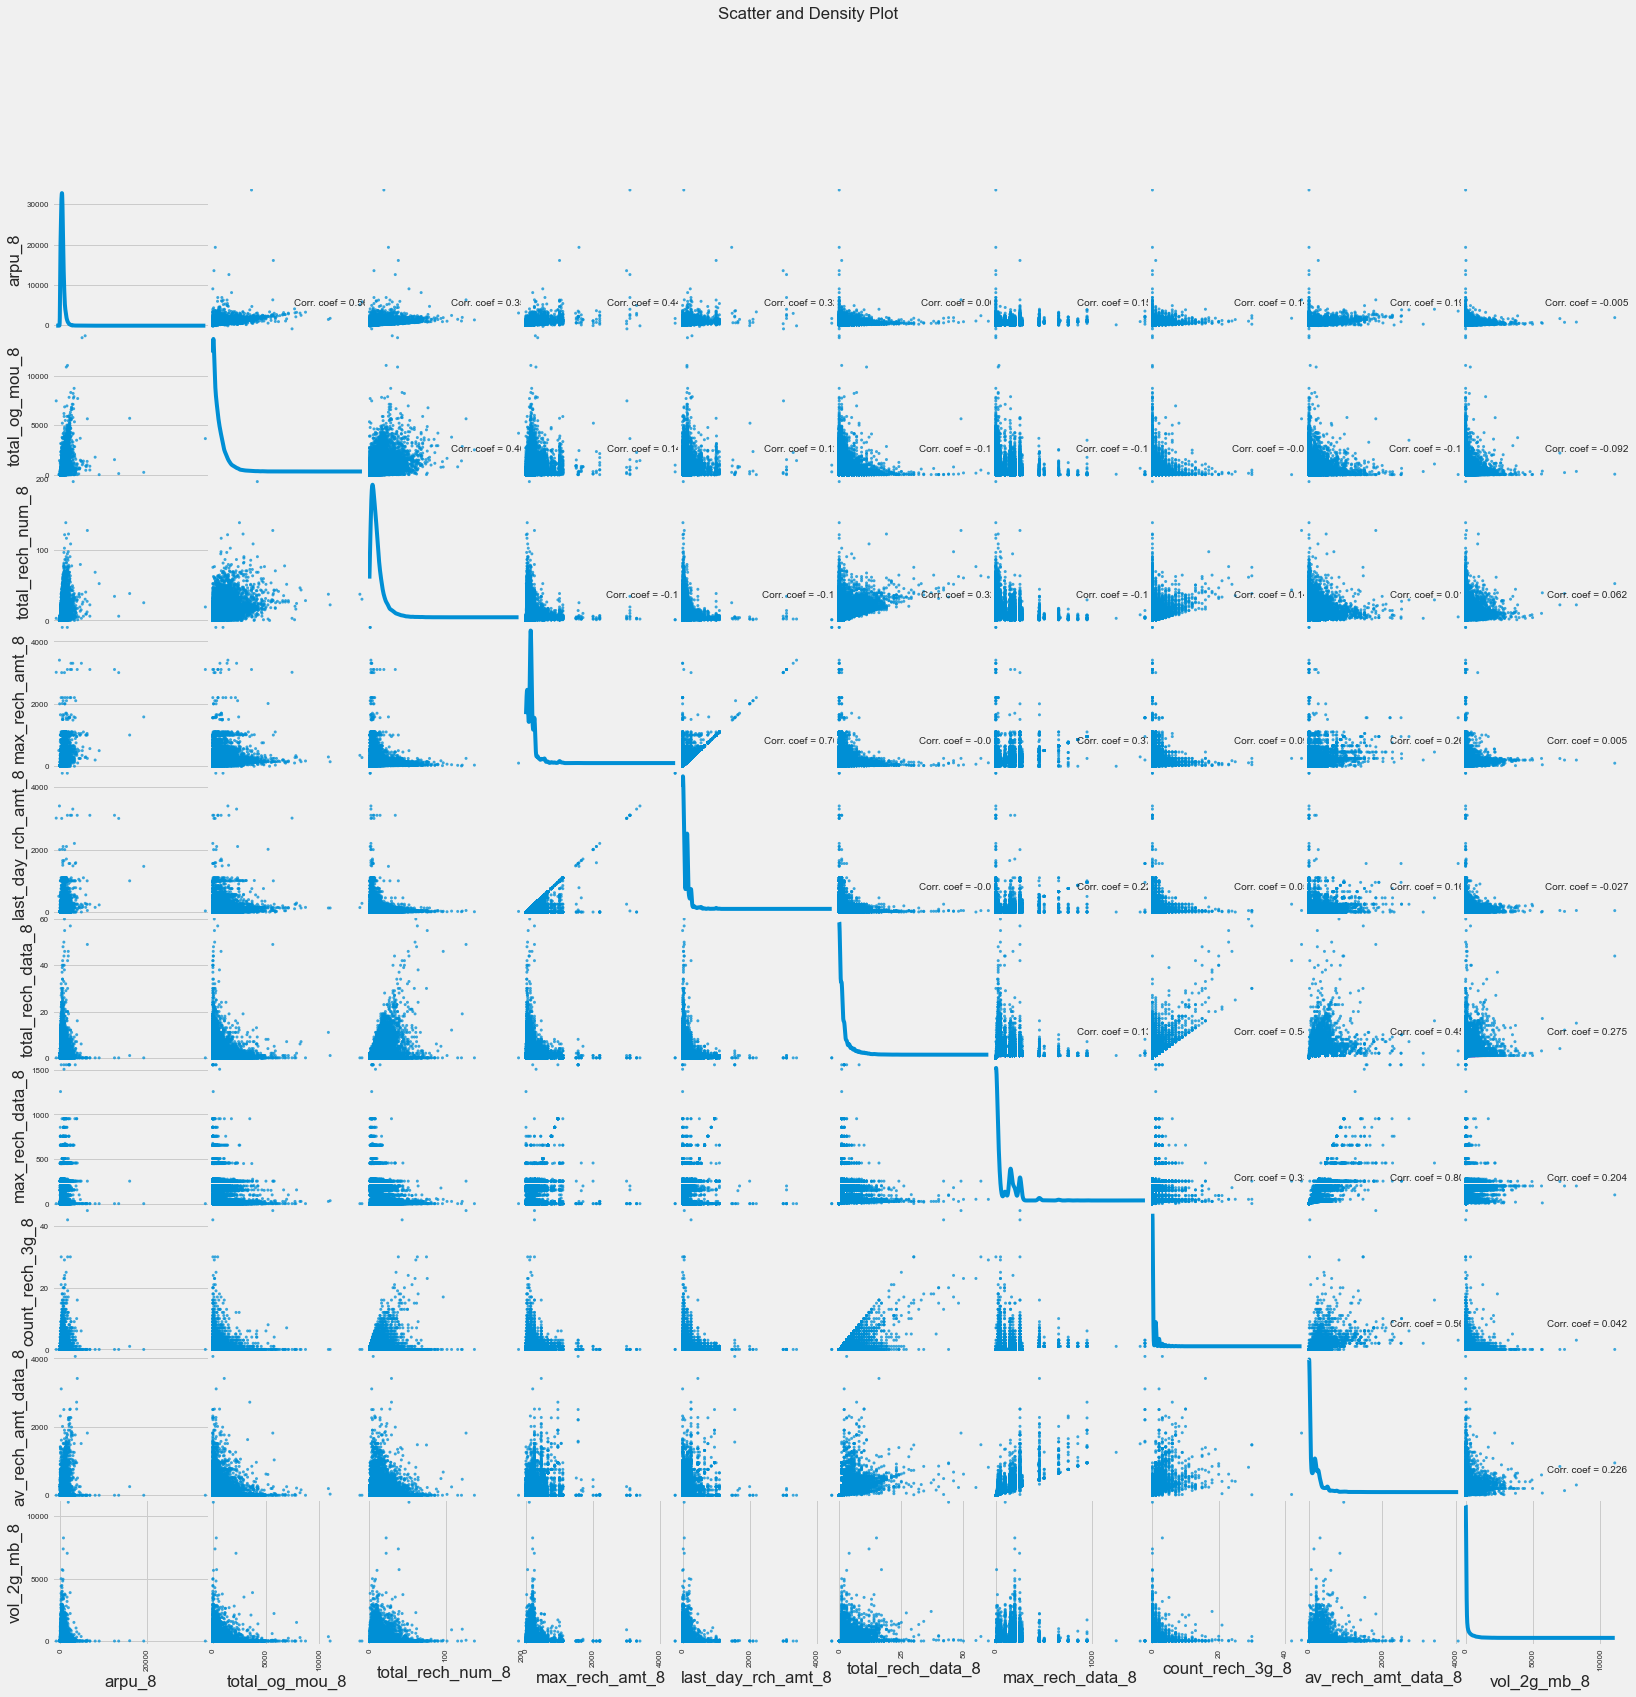

In [212]:
plotScatterMatrix(telecom_df_high_val_cust, 25, 10)

**Observation** :
* Relation between the variables are not obviously linear
* All numeric variables are having distributions which are not normal


**Analysis of Tenure with Churn**

In [213]:
#Convert AON in Months
telecom_df_high_val_cust['aon_mon'] = telecom_df_high_val_cust['aon']/30
telecom_df_high_val_cust.drop('aon', axis=1, inplace=True)
telecom_df_high_val_cust['aon_mon'].head()

0    32.27
7    26.73
8    10.50
21   24.00
23   20.13
Name: aon_mon, dtype: float64

In [214]:
telecom_df_high_val_cust.aon_mon.describe()

count   29953.00
mean       40.31
std        31.91
min         6.00
25%        15.33
50%        28.20
75%        58.53
max       144.03
Name: aon_mon, dtype: float64

Text(0.5, 1.0, 'Customers by their tenure')

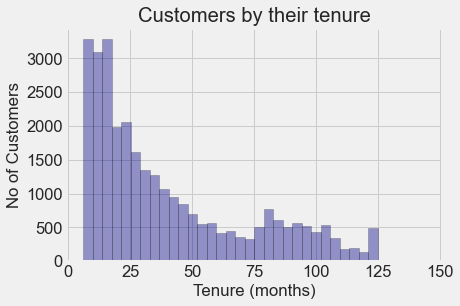

In [215]:
ax = sns.distplot(telecom_df_high_val_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Customers by their tenure')

In [216]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_df_high_val_cust['tenure_range'] = pd.cut(telecom_df_high_val_cust['aon_mon'], tn_range, labels=tn_label)
telecom_df_high_val_cust['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

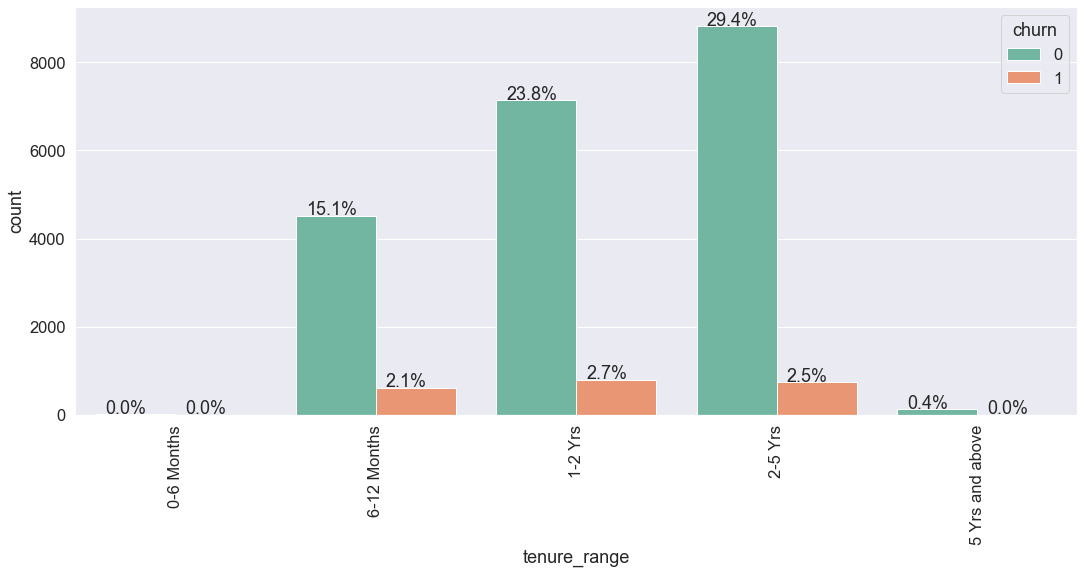

In [217]:
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

temp = pd.Series(data = 'tenure_range')
fig, ax = plt.subplots()
width = len(telecom_df_high_val_cust['tenure_range'].unique()) + 6 + 4*len(temp.unique())
fig.set_size_inches(width , 7)

total = float(len(telecom_df_high_val_cust.index))
ax = sns.countplot(x="tenure_range", data=telecom_df_high_val_cust, palette="Set2", hue = "churn");
for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(telecom_df_high_val_cust))), (p.get_x()+0.05, p.get_height()+20))
plt.xticks(rotation=90)
plt.show()


**Correlation of  Churn with all Variables**

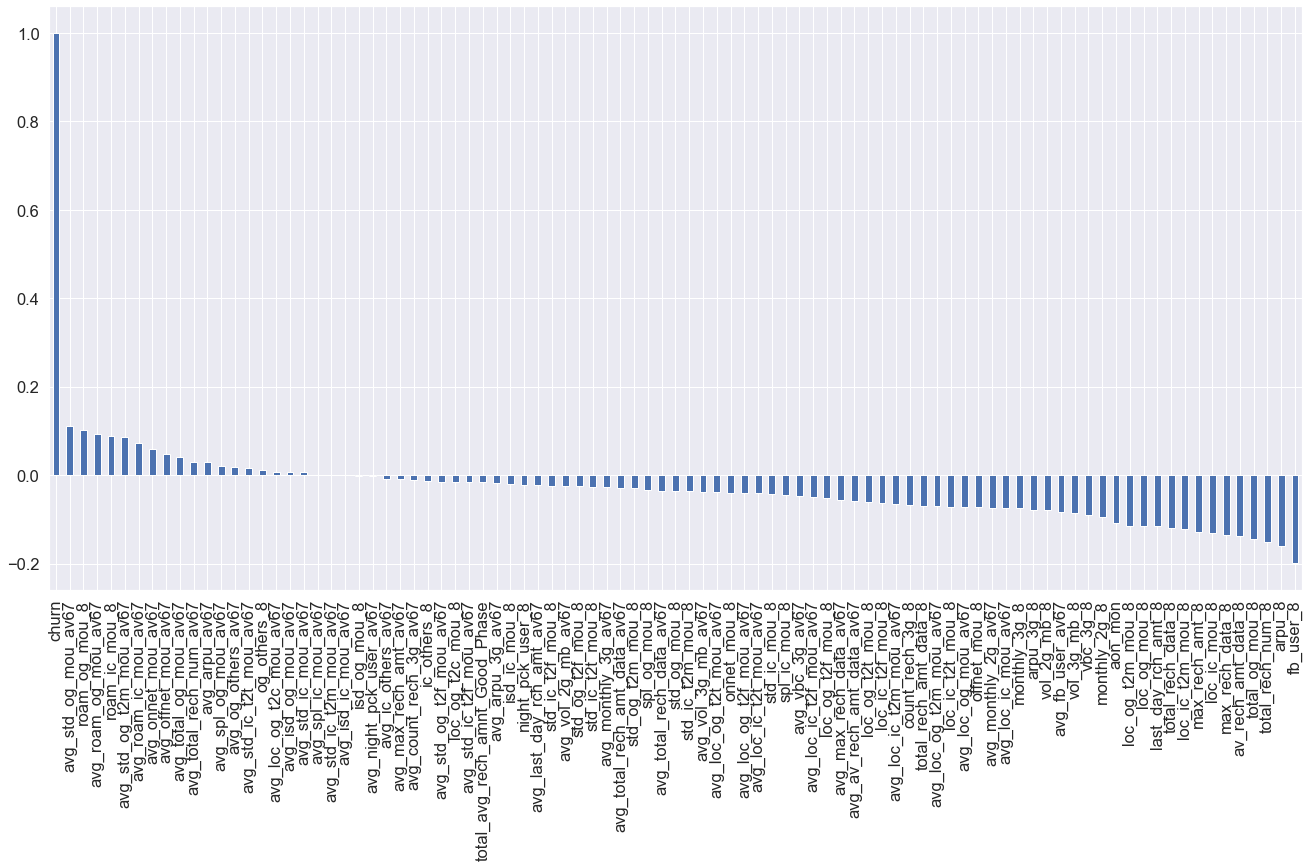

In [218]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(20,10))
telecom_df_high_val_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')
plt.show()

**Observation**

*Positive Corelation with*
- Churn has got maximum correlation with "Avg Std Outgoing Month 6 and 7"
- Roaming Outgoing/Incoming Minutes

*Negative Corelation with*
- fb Usage Plan for 8th Month
- arpu 8th Month
- Total Outgoing 8th Month

Lets also validate if ARPU8 and TotalRech8 are correlated, and if so we should eliminate one of these variables

**Relation between ARPU8 and TotalRecharge Num in 8th Month**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


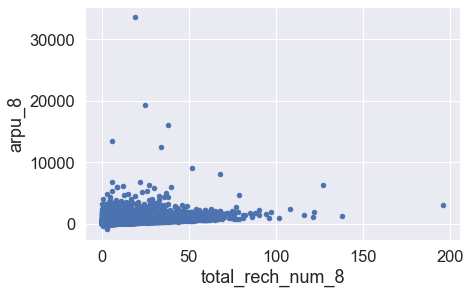

In [219]:
telecom_df_high_val_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')
plt.show()

**Observation** : Looks like they are not correlated and we will keep both the variables

## Step 3: Model Building

Moving towards Model Building
Also drop a **Mobile Number** and **Tenure**


### 3.1 Pre Training Steps ###

In [220]:
## Checkpoint 5

model_df = telecom_df_high_val_cust[:].copy()
telecom_df_high_val_cust.shape


(29953, 92)

In [221]:
#Dropping tenure_range since we have AON MONTH already and columns are highly coorelated
model_df.drop('tenure_range', axis=1, inplace=True)

#dropping total_avg_rech_amnt_Good_Phase which was calculated to find High Value customers.

model_df.drop('total_avg_rech_amnt_Good_Phase', axis=1, inplace=True)

#Since All The Values are realted to Price/ Cost/ Amount, Filling NaN with 0

model_df.fillna(0, inplace=True)

model_df.head()


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,night_pck_user_8,monthly_2g_8,monthly_3g_8,fb_user_8,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_std_og_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_total_og_mou_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_loc_ic_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_std_ic_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_count_rech_3g_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_arpu_3g_av67,avg_night_pck_user_av67,avg_monthly_2g_av67,avg_monthly_3g_av67,avg_fb_user_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67,aon_mon
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,1.00,252.00,1.00,252.00,5.75,109.61,212.17,0.00,0,1,1.00,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,252.00,252.00,1.00,252.00,1.00,252.00,15.72,117.16,212.17,0.00,0.00,1.00,1.00,50.60,252.00,32.27
7,3171.48,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,49.14,16.68,77.84,10.01,6.50,0.00,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,0.00,31.59,15.14,7,1580,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,57.74,0.00,1,1209.51,56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,478.03,40.83,13.37,68.00,0.09,2.25,0.00,548.38,45.20,219.53,126.81,391.56,24.36,109.22,43.22,176.81,0.10,8.29,15.46,5.00,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00,26.73
8,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,75.69,0.00,98.28,0.00,10.23,0.00,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,0.00,0.00,0.00,14,30,10,3.00,23.00,0.00,69.00,0.03,11.94,19.83,0.00,0,0,1.00,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,333.13,11.86,0.00,136.87,0.00,0.00,0.00,470.01,16.84,35.78,0.00,52.63,0.29,13.25,0.00,13.54,0.00,0.00,0.00,20.00,122.00,25.00,1.00,77.00,0.00,88.50,178.00,375.48,0.00,0.00,0.50,0.00,0.50,516.40,177.00,10.50
21,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,876.99,0.00,938.79,0.00,0.00,0.00,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,0.00,0.00,0.00,27,50,50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,95.56,737.05,0.00,848.99,0.00,0.00,0.00,944.57,6.33,96.43,3.73,106.50,10.02,52.96,0.00,62.98,0.00,0.00,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00
23,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,39.61,0.00,39.61,0.00,17.71,0.00,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,0.00,3.74,13.06,4,179,0,2.00,179.00,2.00,270.00,0.01,1009.92,197.27,0.00,0,1,1.00,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,132.80,4.35,0.00,4.35,0.01,0.05,0.00,137.21,40.88,104.63,0.00,145.52,0.26,8.66,0.00,8.92,0.00,14.12,2.67,4.00,89.50,89.50,

In [222]:
# Creating response and predictor variables
response='churn'
predictor=model_df.columns[model_df.columns != 'churn']


#### Split into Train and Test Sets

In cases when classification problems  can exhibit a large imbalance in the distribution of the target classes,  it is recommended to use stratified sampling to ensure that relative class frequencies is approximately preserved in each train and validation fold.

In [223]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(model_df, test_size=0.3, random_state=100,stratify=model_df[response])

#Rows and columns after split
print (df_train.shape)
print (df_test.shape)

(20967, 90)
(8986, 90)


Scale all the predictor variables, so that there is equal weightage to all the features, and convergence is faster

In [224]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[predictor] = scaler.fit_transform(df_train[predictor])
df_test[predictor] = scaler.transform(df_test[predictor])


In [225]:
df_train.churn.value_counts()

0    19264
1     1703
Name: churn, dtype: int64

In [226]:
# X_train, y_train
X_train = df_train.drop('churn', axis=1)
y_train = df_train['churn']

# X_test, y_test
X_test = df_test.drop('churn', axis=1)
y_test = df_test['churn']

### 3.2 Model Training ###

*Approach*
- We will first train a Logistical Regression Model, which will form our Baseline
- We will then try  to try a Kernel and Random Forest and try to improve on our baseline
- Kernel Model we will use PCA and optimise for Prediction 
- Random Forest Model we will optimise Forecasting and use it for find the important features

Correct Imbalance in the Data Sets using SMOTE
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/



We will over-sample the positive class (churn = 1) to an equivalent number as the negative class using SMOTE and use the balanced training data to train a logit model. 

Finally we we will test the model on a unbalanced validation set.



#### Variable Importance using RFE and Cross Validation

We will find the optimal number of features to use in a Logistic Regression model and the list of features by using recursive feature elimination method along with 5-fold cross validation.

In [227]:
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score,precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools

In [228]:
def rfe_cv(x_train_data,y_train_data):
    rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='recall')
    rfecv.fit(x_train_data, y_train_data)
    
    selected_features=list(x_train_data.columns[rfecv.support_])
    
    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % selected_features)

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(10,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (Recall)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    return(selected_features)

Optimal number of features: 84
Selected features: ['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'arpu_3g_8', 'night_pck_user_8', 'monthly_2g_8', 'monthly_3g_8', 'fb_user_8', 'vbc_3g_8', 'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67', 'avg_loc_og_t2f_mou_av6

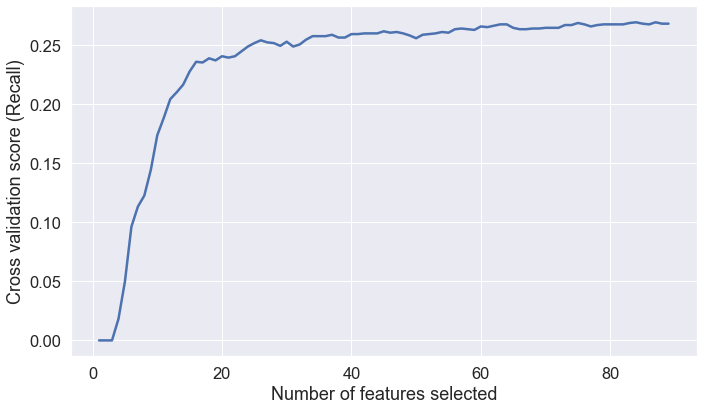

In [229]:
rfe_predictors=rfe_cv(X_train, y_train)




We have got 84 features using recursive feature elimination with cross validation



### Logistic Regression and Cross Validation


We will training a logistic regression and test it on a validation set. For this we will define 2 functions:

    To train a Logit model and test it on a validation set
    To evaluate the Logit model using Stratified K-fold cross-validation



In [280]:
def model_fit_metrics(y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob, plot=True):
      
    prf_train=precision_recall_fscore_support(y_train, y_train_pred,pos_label =1, average ='binary')
    prf_test=precision_recall_fscore_support(y_test, y_test_pred,pos_label =1, average ='binary')
    area_prc_train=average_precision_score(y_train, y_train_pred_prob,average=None)
    area_prc_test=average_precision_score(y_test, y_test_pred_prob,average=None)
    auc_train = round(roc_auc_score(y_train, y_train_pred),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred),2)
    accuracy_train = round(accuracy_score(y_train, y_train_pred),2)
    accuracy_test = round(accuracy_score(y_test, y_test_pred),2)
    
    
    precision_train, recall_train, thr_train = precision_recall_curve(y_train, y_train_pred_prob,pos_label =1)
    precision_test, recall_test, thr_test = precision_recall_curve(y_test, y_test_pred_prob,pos_label =1)
    
   
    print ("Model report on training data:")
    print ("Train: Accuracy : %.4g" % (accuracy_train*100))
    print ("Train: Precision: %.4g" % (prf_train[0]*100))
    print ("Train: Recall : %.4g" % (prf_train[1]*100))
    print ("Train: AUC : %.4g" % (auc_train*100))
    print ("Average Precision (Train): %.4g" % (area_prc_train*100))
    print ("\nModel report on test data:")
    print ("Test: Accuracy : %.4g" % (accuracy_test*100))
    print ("Test: Precision: %.4g" % (prf_test[0]*100))
    print ("Test: Recall : %.4g" % (prf_test[1]*100))
    print ("Test: AUC : %.4g" % (auc_test*100))
    print ("Average Precision (Test): %.4g" % (area_prc_test*100))

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(recall_test, precision_test, color='coral',label=' Test PR-Curve')
        plt.plot(recall_train, precision_train, color='green',label=' Train PR-Curve')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()
    

In [267]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    y_train_pred_prob = alg.predict_proba(X_train_data)[:,1]
    
    y_test_pred = alg.predict(X_test_data)
    y_test_pred_prob = alg.predict_proba(X_test_data)[:,1]
    
    model_fit_metrics(y_train_data, y_train_pred, y_train_pred_prob, y_test_data, y_test_pred, y_test_pred_prob, plot)
  

In [268]:
#Function for K-Fold Stratified Cross_validation of any model
def cv_modelfit(alg,dtrain,predictors,response,cvfolds):

    skf = StratifiedKFold(n_splits=cvfolds,random_state=2)
    cv_results = np.zeros((cvfolds, 3))
    for i, (train_index, test_index) in enumerate(skf.split(dtrain[predictors],dtrain[response])):
        for j in range(0,3):
            cvtrain=dtrain.iloc[train_index]
            cvtest=dtrain.iloc[test_index]

            #Fit the algorithm on the data
            alg.fit(cvtrain[predictors], cvtrain[response])

            #Predict training set:
            dtrain_pred = alg.predict(cvtrain[predictors])
            dtrain_predprob = alg.predict_proba(cvtrain[predictors])[:,1]

            dtest_pred = alg.predict(cvtest[predictors])
            dtest_predprob = alg.predict_proba(cvtest[predictors])[:,1]

            prf_train=precision_recall_fscore_support(cvtrain[response], dtrain_pred,pos_label =1, average ='binary')
            prf_test=precision_recall_fscore_support(cvtest[response], dtest_pred,pos_label =1, average ='binary')
            area_prc_test=average_precision_score(cvtest[response], dtest_predprob,average=None)
            area_prc_train=average_precision_score(cvtrain[response], dtrain_predprob,average=None)


            cvr=[prf_test[0],prf_test[1],area_prc_test]
            cv_results[i,j]=cvr[j]

    print ("Mean CV Test Precision: %.4g" % (cv_results[:,0].mean()*100))
    print ("Mean CV Test Recall: %.4g" % (cv_results[:,1].mean()*100))
    print ("Std.Devation of CV Test Precision: %.4g" % (cv_results[:,0].std()*100))
    print ("Std.Devation of CV Test Recall: %.4g" % (cv_results[:,1].std()*100))




Split the training data set into training and validation data sets.


In [232]:
train, test = train_test_split(df_train,test_size=0.3, random_state=2,stratify=df_train[response])



#### Baseline Logistic Regression Model

In [269]:
logreg1 = LogisticRegression(penalty = 'l1', solver='saga', random_state = 2)


Model report on training data:
Train: Accuracy : 93
Train: Precision: 69.58
Train: Recall : 19.38
Train: AUC : 59
Average Precision (Train): 52.15

Model report on test data:
Test: Accuracy : 93
Test: Precision: 65.19
Test: Recall : 20.16
Test: AUC : 60
Average Precision (Test): 51.54


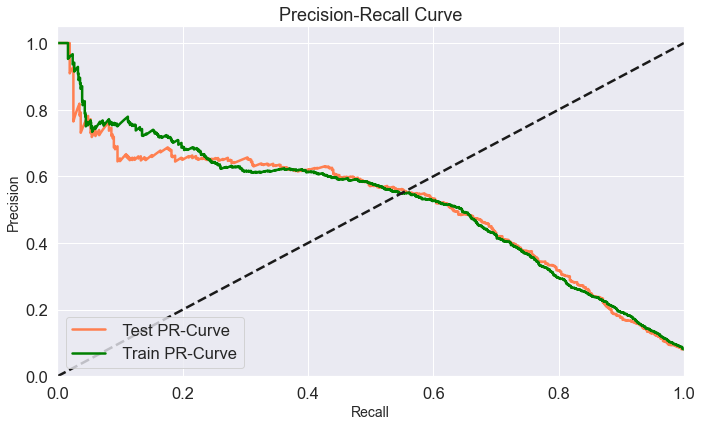

In [278]:
model_fit(logreg1,train[rfe_predictors], train[response], test[rfe_predictors], test[response] ,True)



The baseline logistic regression model gave a Recall of 20.16% and Precision of 65.19% on a validation set. We actually need a model with higher recall value to be able to predict the churn customers. Since the results from a validation set approach could have high variability, we will use 10-fold cross validation to validate the model accurately.



### Model evaluation with 10-Fold Cross Validation

We will use 10-fold cross validation to accurately evaluate the model scores.


In [235]:
cv_modelfit(logreg1,df_train,rfe_predictors,response,10)


Mean CV Test Precision: 67.07
Mean CV Test Recall: 20.14
Std.Devation of CV Test Precision: 6.006
Std.Devation of CV Test Recall: 2.764


Mean test recall from 10-fold cross validation is 20.14% and precision is 67.07%. This means the model accurately predicts churn 20.14% of the time and 67.07% of the predicted churn are actually churned customers.
But we need a model that has high recall value as the cost of misclassifying churn is higher for the company. So we will try to balance the data by over-sampling the positive class using synthetic over-sampling method SMOTE.


## Balancing by over-sampling minority class using SMOTE

We will start by balancing the data set using SMOTE technique. First we will balance the data set by SMOTE and then apply logistic regression model on the balanced data set.
SMOTE technique should be applied only on the training data, after splitting the data set into training set and validation set. If we apply SMOTE before splitting the data, we would leak the information in validation set into the training set. We will define a function to balance the data and train a model.


In [283]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def model_fit_smote(alg,sam_alg,data,predictors,response,plot=True):

    dtrain, dtest = train_test_split(data, test_size=0.3, random_state=2,stratify=data[response])

    
    X_smt, y_smt=sam_alg.fit_sample(train[predictors],train[response])
    X_smt=pd.DataFrame(X_smt)
    columns=train[predictors].columns
    X_smt.columns=columns

    #Fit the algorithm on the data
    alg.fit(X_smt[predictors], y_smt)

    #Predict training set:
    y_train_pred = alg.predict(X_smt[predictors])
    y_train_pred_prob = alg.predict_proba(X_smt[predictors])[:,1]

    y_test_pred = alg.predict(dtest[predictors])
    y_test_pred_prob = alg.predict_proba(dtest[predictors])[:,1]#/k  

    model_fit_metrics(y_smt, y_train_pred, y_train_pred_prob, dtest[response], y_test_pred, y_test_pred_prob, plot)
   



We will over-sample the positive class to an equivalent number as the negative class using SMOTE and use the balanced training data to train a logit model. But we will test the model on a unbalanced validation set.


In [237]:
#Applying SMOTE
#We wont be applying Smote on the Test Data Set

import imblearn
from imblearn.over_sampling import SMOTE
try:
    print(imblearn.__version__)
except:
    print("Please install SMOTE Package First")


0.7.0


In [238]:
sampling1=SMOTE(sampling_strategy=1.0, random_state=2, k_neighbors=5,  n_jobs=-1)


Model report on training data:
Train: Accuracy : 83
Train: Precision: 82.5
Train: Recall : 84.06
Train: AUC : 83
Average Precision (Train): 90.1

Model report on test data:
Test: Accuracy : 82
Test: Precision: 28.56
Test: Recall : 83.56
Test: AUC : 83
Average Precision (Test): 50.42


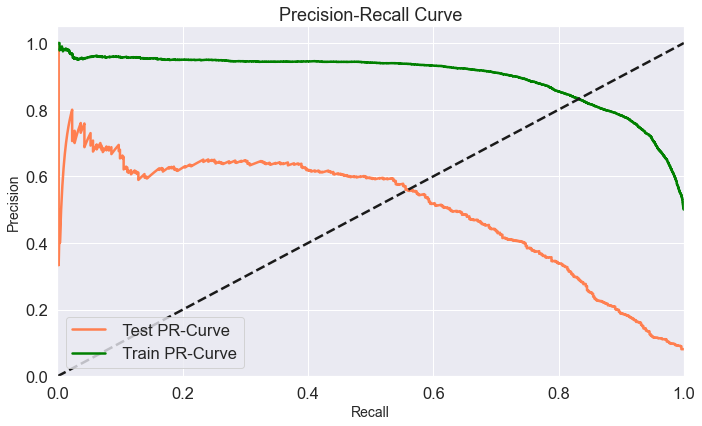

In [284]:
model_fit_smote(logreg1,sampling1,df_train,rfe_predictors,response,plot=True)

Over-sampling the minority class improved the recall from 20.16% to 83.56% but the precision decreased from 65.19% to 28.56%. We will try to find the optimal ratio for over-sampling the minority class so that we get decent balance between recall and precision.
We will define a function that trains a model on the balanced data with a given ratio of minority over-sampling and gives the test precision and recall on a validation set.


In [240]:
def smote_eval(alg,data,predictors,response,r):

    smt=SMOTE(sampling_strategy=r, random_state=2, k_neighbors=5,  n_jobs=-1)
    X_smt, y_smt=smt.fit_sample(train[predictors],train[response])
    X_smt=pd.DataFrame(X_smt)
    columns=train[predictors].columns
    X_smt.columns=columns

    #Fit the algorithm on the data
    alg.fit(X_smt[predictors], y_smt)
            
    dtest_pred = alg.predict(test[predictors])
    dtest_predprob = alg.predict_proba(test[predictors])[:,1]  

    prf_test=precision_recall_fscore_support(test[response], dtest_pred,pos_label =1, average ='binary')
    
    return(prf_test[0],prf_test[1])

In [241]:
smt_ratio = np.zeros((10, 3))
for i in range(0,10,1):
    for j in range(0,3,1):
        temp=np.append(smote_eval(logreg1,df_train,rfe_predictors,response,float(i+1)/float(10)),float(i+1)/float(10))
        smt_ratio[i,j]=temp[j]

In [242]:
smt_ratio=pd.DataFrame(smt_ratio)
smt_ratio.columns=['Precision','Recall','Ratio']
smt_ratio

,Precision,Recall,Ratio
0,0.66,0.28,0.10
1,0.54,0.59,0.20
2,0.47,0.67,0.30
3,0.43,0.71,0.40
4,0.40,0.74,0.50
5,0.37,0.77,0.60
6,0.35,0.79,0.70
7,0.32,0.81,0.80
8,0.30,0.83,0.90
9,0.29,0.84,1.00




Though higher recall value is important for us but we want to get a decent balance between precision and recall as well in solving this problem.

Note: Depending on what the business goal is, we can adjust this parameter but an important point to keep in mind is that improvement in recall comes at the cost of precision.


In [243]:
sampling2=SMOTE(sampling_strategy=0.5, random_state=2, k_neighbors=5,  n_jobs=-1)

Model report on training data:
Train: Accuracy : 86
Train: Precision: 79.71
Train: Recall : 75.81
Train: AUC : 83
Average Precision (Train): 83.605503

Model report on test data:
Test: Accuracy : 89
Test: Precision: 39.75
Test: Recall : 73.97
Test: AUC : 82
Average Precision (Test): 51.788577


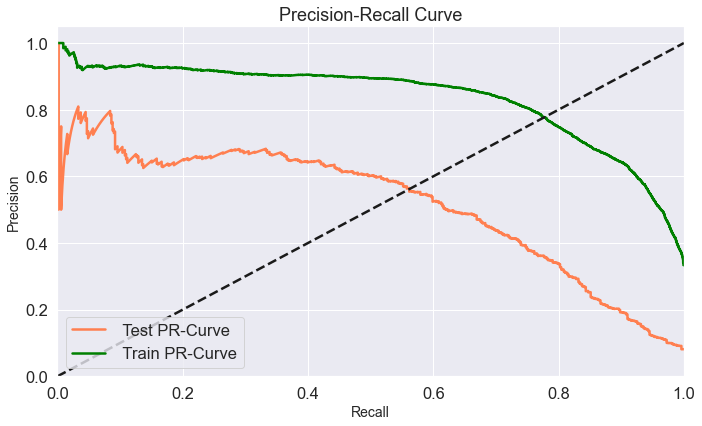

In [244]:
model_fit_smote(logreg1,sampling2,df_train,rfe_predictors,response,plot=True)


Model Evaluation using 10-fold Cross Validation

In [245]:
#Function for K-Fold Stratified Cross_validation of any model
def cv_smotemodel(alg,sam_alg,dtrain,predictors,response,cvfolds):

    skf = StratifiedKFold(n_splits=cvfolds,random_state=2)
    cv_results = np.zeros((cvfolds, 3))
    for i, (train_index, test_index) in enumerate(skf.split(dtrain[predictors],dtrain[response])):
        for j in range(0,3):
            cvtrain=dtrain.iloc[train_index]
            cvtest=dtrain.iloc[test_index]
            
            X_smt, y_smt=sam_alg.fit_sample(cvtrain[predictors], cvtrain[response])
            X_smt=pd.DataFrame(X_smt)
            columns=train[predictors].columns
            X_smt.columns=columns
            

            #Fit the algorithm on the data
            alg.fit(X_smt[predictors], y_smt)

            #Predict training set:
            dtrain_pred = alg.predict(X_smt[predictors])
            dtrain_predprob = alg.predict_proba(X_smt[predictors])[:,1]

            dtest_pred = alg.predict(cvtest[predictors])
            dtest_predprob = alg.predict_proba(cvtest[predictors])[:,1]

            prf_train=precision_recall_fscore_support(y_smt, dtrain_pred,pos_label =1, average ='binary')
            prf_test=precision_recall_fscore_support(cvtest[response], dtest_pred,pos_label =1, average ='binary')
            area_prc_test=average_precision_score(cvtest[response], dtest_predprob,average=None)
            area_prc_train=average_precision_score(y_smt, dtrain_predprob,average=None)


            cvr=[prf_test[0],prf_test[1],area_prc_test]
            cv_results[i,j]=cvr[j]

    print ("Mean CV Test Precision: %.4g" % (cv_results[:,0].mean()*100))
    print ("Mean CV Test Recall: %.4g" % (cv_results[:,1].mean()*100))
    print ("Std.Devation of CV Test Precision: %.4g" % (cv_results[:,0].std()*100))
    print ("Std.Devation of CV Test Recall: %.4g" % (cv_results[:,1].std()*100))

In [246]:
cv_smotemodel(logreg1,sampling2,df_train,rfe_predictors,response,10)

Mean CV Test Precision: 39.66
Mean CV Test Recall: 72.46
Std.Devation of CV Test Precision: 1.843
Std.Devation of CV Test Recall: 4.192


Mean test recall from 10-fold cross validation is 72.46% and precision is 39.66%. This means the model accurately predicts customer churn as churn 72.46% of the time and 39.66% of the predicted churn  are actually churn. This is a good recall and decent precision for a model to detect minority class samples in a unbalanced data set.
We might be able to further improve the model by tuning the hyperparameters penalty and C in the logit model.



### Hyperparameter Tuning using GridSearch+CV

We will tune both the hyperparameters i.e. penalty and C using GridSearch on a range of values and cross validation. We will define a function for grid search and cross validation.


In [247]:
#def grid_tune(param_test,scores):
def grid_tune(hyper_params, scores):    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print

        clf = GridSearchCV(LogisticRegression(solver='saga'), hyper_params, cv=5,
                           scoring=score)
        smt=SMOTE(sampling_strategy=0.5, random_state=2, k_neighbors=5,  n_jobs=-1)
        X_smt, y_smt=smt.fit_sample(train[rfe_predictors],train[response])
        X_smt=pd.DataFrame(X_smt)
        columns=train[rfe_predictors].columns
        X_smt.columns=columns
        
        clf.fit(X_smt[rfe_predictors], y_smt)

        print("Best parameters set found on development set:")
        print
        print(clf.best_params_,clf.best_score_)
        print
        print("Grid scores on development set:")
        print
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))



Since we don't know the exact range of values to search for C, let's start with a set of values to narrow down the range and then search for optimal value within that range in the next step.


In [249]:
# Set to n_estimators to the tuned values from cross-validation

scores1 = ['recall','precision']
param_test1 = {
 'penalty':['l1','l2'],
 'C':[0.001, 0.01, 0.1, 1, 10, 100]
}
grid_tune(param_test1,scores1)



# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 100, 'penalty': 'l2'} 0.7554164751117983
Grid scores on development set:
0.591 (+/-0.018) for {'C': 0.001, 'penalty': 'l1'}
0.724 (+/-0.024) for {'C': 0.001, 'penalty': 'l2'}
0.736 (+/-0.028) for {'C': 0.01, 'penalty': 'l1'}
0.750 (+/-0.025) for {'C': 0.01, 'penalty': 'l2'}
0.753 (+/-0.028) for {'C': 0.1, 'penalty': 'l1'}
0.755 (+/-0.025) for {'C': 0.1, 'penalty': 'l2'}
0.755 (+/-0.024) for {'C': 1, 'penalty': 'l1'}
0.755 (+/-0.025) for {'C': 1, 'penalty': 'l2'}
0.755 (+/-0.025) for {'C': 10, 'penalty': 'l1'}
0.755 (+/-0.025) for {'C': 10, 'penalty': 'l2'}
0.755 (+/-0.025) for {'C': 100, 'penalty': 'l1'}
0.755 (+/-0.025) for {'C': 100, 'penalty': 'l2'}
# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 0.001, 'penalty': 'l1'} 0.8497298875322699
Grid scores on development set:
0.850 (+/-0.028) for {'C': 0.001, 'penalty': 'l1'}
0.806 (+/-0.021) for {'C': 0.001

We can fix to 1 as the optimal value of hyperparameter C using l1 regularization.


### Training and Testing the final model

We will define a function to compute and plot the confusion matrix on the test data set. We will train the final model on the entire training data set and predict the results on the test set.


In [251]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Test AUC:  82.0
Test Accurancy:  89.0
Test Recall:  74.79
Test Precision:  40.15

Confusion matrix, without normalization


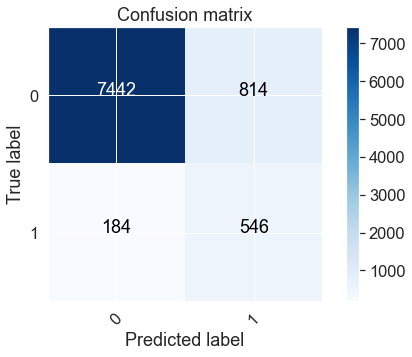

In [252]:
sampling2=SMOTE(sampling_strategy=0.5, random_state=2, k_neighbors=5,  n_jobs=-1)

X_smt, y_smt=sampling2.fit_sample(df_train[rfe_predictors],df_train[response])
X_smt=pd.DataFrame(X_smt)
columns=df_train[rfe_predictors].columns
X_smt.columns=columns

#Fit the algorithm on the data
alg = LogisticRegression(penalty = 'l1', C=1,random_state = 2, solver='saga')
alg.fit(X_smt[rfe_predictors], y_smt)

#Predict test set:
dtest_pred = alg.predict(df_test[rfe_predictors])
dtest_predprob = alg.predict_proba(df_test[rfe_predictors])[:,1]


prf_test=precision_recall_fscore_support(df_test[response], dtest_pred,pos_label =1, average ='binary')
area_prc_test=average_precision_score(df_test[response], dtest_predprob,average=None)
auc_test = round(roc_auc_score(df_test[response],dtest_pred),2)
accuracy_test = round(accuracy_score(df_test[response],dtest_pred),2)

# Compute confusion matrix
cnf_matrix = confusion_matrix(df_test[response],dtest_pred)


print ("Test AUC: ",auc_test*100)
print ("Test Accurancy: ",accuracy_test*100)
print ("Test Recall: ",round((prf_test[1]*100),2))
print ("Test Precision: ",round((prf_test[0]*100),2))
print ()

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(7,5))
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

We acheived a recall value of 74.79% and a precision of 40.15% on the test set. This is a very decent prediction power on a unbalanced data set using Logistic Regression. 

Using tree based algorithms like Random Forestes and Xgboost on the data set could further improve the predictions as those algorithms can model complex interactions between the features 

## Tree Model Regression



In [286]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [287]:
# Split the train sample into train and test sample
train, test = train_test_split(df_train,test_size=0.3, random_state=2,stratify=df_train[response])

Model report on training data:
Train: Accuracy : 100
Train: Precision: 100
Train: Recall : 100
Train: AUC : 100
Average Precision (Train): 100

Model report on test data:
Test: Accuracy : 94
Test: Precision: 73.15
Test: Recall : 46.38
Test: AUC : 72
Average Precision (Test): 63.46


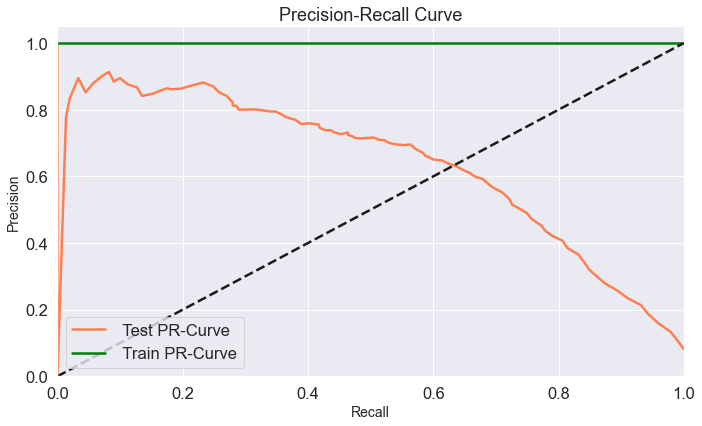

In [290]:
rfc = RandomForestClassifier()
model_fit(rfc,train[predictor], train[response], test[predictor], test[response] ,True)

The baseline Random Forest regression model gave a Recall of 46.38% and Precision of 73.15% on a validation set. We actually need a model with higher recall value to be able to predict the churn customers. Since the results from a validation set approach could have high variability, we will use 10-fold cross validation to validate the model accurately.


### Model evaluation with 10-Fold Cross Validation

We will use 10-fold cross validation to accurately evaluate the model scores.


In [291]:
cv_modelfit(rfc,df_train, predictor,response,10)


Mean CV Test Precision: 74.98
Mean CV Test Recall: 45.8
Std.Devation of CV Test Precision: 4.029
Std.Devation of CV Test Recall: 5.235


Mean test recall from 10-fold cross validation is 45.8% and precision is 74.98%. This means the model accurately predicts churn 45.8% of the time and 74.98% of the predicted churn are actually churned customers. But we need a model that has high recall value as the cost of misclassifying churn is higher for the company. So we will try to balance the data by over-sampling the positive class using synthetic over-sampling method SMOTE.

In [293]:
sampling_rfc_1=SMOTE(sampling_strategy=1.0, random_state=2, k_neighbors=5,  n_jobs=-1)

Model report on training data:
Train: Accuracy : 100
Train: Precision: 100
Train: Recall : 100
Train: AUC : 100
Average Precision (Train): 100

Model report on test data:
Test: Accuracy : 93
Test: Precision: 56.09
Test: Recall : 65.75
Test: AUC : 81
Average Precision (Test): 61.27


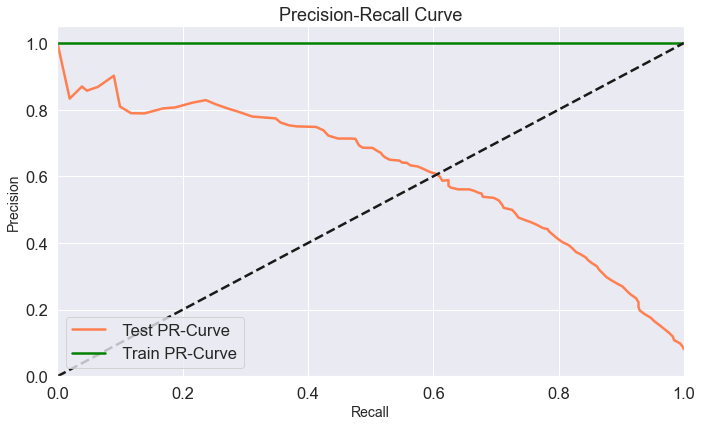

In [294]:
model_fit_smote(rfc,sampling_rfc_1,df_train,predictor,response,plot=True)

Over-sampling the minority class improved the recall from 46.38% to 65.75% but the precision decreased from 73.15% to 56.09%. We will try to find the optimal ratio for over-sampling the minority class so that we get decent balance between recall and precision.



In [295]:
smt_ratio = np.zeros((10, 3))
for i in range(0,10,1):
    for j in range(0,3,1):
        temp=np.append(smote_eval(rfc,df_train,predictor,response,float(i+1)/float(10)),float(i+1)/float(10))
        smt_ratio[i,j]=temp[j]

In [296]:
smt_ratio=pd.DataFrame(smt_ratio)
smt_ratio.columns=['Precision','Recall','Ratio']
smt_ratio

,Precision,Recall,Ratio
0,0.72,0.47,0.10
1,0.68,0.55,0.20
2,0.65,0.58,0.30
3,0.62,0.60,0.40
4,0.61,0.61,0.50
5,0.58,0.62,0.60
6,0.58,0.64,0.70
7,0.59,0.66,0.80
8,0.58,0.65,0.90
9,0.57,0.66,1.00



Ratio of 1 is giving us good recall and Precision. We will continue with same ration for SMOTE


### Hyperparameter Tuning using GridSearch+CV

We will tune both the hyperparameters i.e. penalty and C using GridSearch on a range of values and cross validation. We will define a function for grid search and cross validation.
